# Specific Case Study analysis
In this notebook we will produce all the necessary visualizations that are might be useful for the paper.
From these visualizaitons a subset will be used in the paper.

特定案例分析
在本笔记本中，我们将制作所有可能对论文有所帮助的必要可视化图表。
论文中将使用这些可视化结果中的一个子集。

In [1]:
import sys
sys.path.insert(0, '../../') # 添加项目根目录到Python路径，以便导入多层级的模块

import os      # 操作系统接口，用于文件路径操作
import re      # 正则表达式库，用于字符串模式匹配
import numpy as np  # 数值计算库，提供数学函数和数组操作
import networkx as nx  # 复杂网络分析库，用于构建和分析图结构
import pyvis.network as network  # 交互式网络可视化库
import seaborn as sns  # 统计可视化库，基于matplotlib的增强版
import pandas as pd    # 数据处理库，用于数据框操作
from scipy.stats import mode  # 统计函数，用于计算众数
import graphviz        # 图形可视化库，用于绘制有向图
import tabulate as tabulate  # 表格格式化库，用于美化数据框显示
from graphviz import Digraph  # 有向图绘制工具
from matplotlib.colors import LinearSegmentedColormap  # 自定义颜色映射

import matplotlib.pyplot as plt
%matplotlib inline

import tikzplotlib# LaTeX图表导出库，用于生成论文质量的矢量图
# 论文意义：生成可直接插入LaTeX文档的高质量图表

# Agent Info -> directories, names, ...
# 导入实验配置信息，包含智能体实验设置
from script.experiments_constants import AGENT_EXPERIMENT_INFO
from constants import PROJ_ADDR # 导入项目地址常量，定义数据存储根路径

# KPI list and kpi effect list # 导入环境关键性能指标名称列表
from script.experiments_constants import ENV_KPI_NAME_LIST

from script.utils import create_effects_list, create_decisions_list, ensure_directory_exists
# 从utils模块导入工具函数：
# - create_effects_list: 生成符号化效果列表
# - create_decisions_list: 生成符号化决策列表
# - ensure_directory_exists: 确保目录存在的工具函数
# 论文应用：提供可重用的分析工具函数

# Action steering specific loading numerical data and
# 导入数据加载函数，负责数据预处理流水线
from script.load_data import handle_data
# 导入符号化表示创建函数，SYMBXRL方法的核心
from script.symbolic_representation import create_symbolic_state_decision_matrix

# Probability Comparison functions
from script.probability_comparison import plot_and_save_probability_dist_comparison_heatmaps_with_clustering
# 导入概率比较函数，用于生成聚类热力图
# 论文应用：比较不同实验条件下的概率分布模式

In [2]:
PROJ_ADDR

'/share/home/user018/SYMBXRL'

### Utils
This utility functions will be used as helper to avoid repeating code.

工具类
这些实用函数将作为辅助工具，以避免代码重复。

In [3]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    matplotlib 3.6将图例的_ncol属性重命名为_ncols的兼容性修复函数
    """
    # 检查对象是否有_ncols属性（matplotlib 3.6+）
    if hasattr(obj, "_ncols"):
        # 将_ncols的值赋给_ncol属性，保持向后兼容
        obj._ncol = obj._ncols
        # 修复原理：tikzplotlib期望使用旧的_ncol属性名，
        # 但matplotlib 3.6将其重命名为_ncols，导致导出失败

    # 递归处理所有子对象，确保修复应用到整个图形层次结构
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
        # 递归调用，处理当前对象的所有子对象
        # 这包括坐标轴、图例、文本标签等所有图形元素

In [4]:
def create_plot_dir_for_results(analysis_name, result_dir_addrr=PROJ_ADDR):
    """Create the directory path for storing data."""
    # 创建用于存储数据的目录路径
    # 论文应用：系统化管理分析结果文件，确保输出组织有序

    # 构建目录路径字符串
    str_helper = f"A1-NetworkSlicingSchedulingPolicy/results/{analysis_name}"
    # 目录结构模板：项目名称/结果/分析类型/
    # 示例：
    # - "A1-NetworkSlicingSchedulingPolicy/results/decision_graphs"
    # - "A1-NetworkSlicingSchedulingPolicy/results/probability_heatmaps"
    # - "A1-NetworkSlicingSchedulingPolicy/results/association_rules"
    # 论文意义：标准化的结果组织，便于文件管理和查找

    # 拼接完整路径
    path = os.path.join(result_dir_addrr, str_helper)
    # os.path.join() 安全地拼接路径，自动处理不同操作系统的路径分隔符
    # 示例输出："/home/user/project/A1-NetworkSlicingSchedulingPolicy/results/decision_graphs"

    # 确保目录存在（不存在则创建）
    ensure_directory_exists(path)
    # 调用工具函数创建目录，包括所有必要的父目录

    # 返回创建的路径
    return path

-----

## Plot mean KPI values for all users per slice【将状态空间以图形绘制出来】
These plots will show the mean KPI values for all users both combined and per slice.
The goal is to provide a general overview of the raw numerical data.

按切片绘制所有用户的平均关键绩效指标（KPI）值

这些图表将展示所有用户的平均关键绩效指标（KPI）值，包括总体和每个切片的值。

目标是对原始数值数据提供一个总体概述。

【以智能体、切片维度拆分文件，保留kpi维度拆分子图】

In [5]:
# 设置matplotlib全局字体大小，提高图表可读性
plt.rcParams.update({'font.size': 14})  # Increase the default font size
# 论文意义：确保图表中的文字在论文中清晰可读，符合出版标准

# 定义分析名称和参数
analysis_name = "Plots_for_Paper"  # 专门为论文准备的图表
users = range(3, 7)  # 用户范围：3,4,5,6 [3,4,5,6]
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]  # 所有4种智能体类型
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']  # 三个关键性能指标
slices = [0, 1, 2]  # 三个网络切片，Assuming slices are 0, 1, 2

# 遍历所有智能体类型
for agent in agents:
     # 创建当前智能体的图表保存目录
    plot_path = create_plot_dir_for_results(analysis_name + f"/1_Numeric_KPI_Per_Slice/{agent}")
      # 目录结构：Plots_for_Paper/1_Numeric_KPI_Per_Slice/{agent}/
    # 论文意义：按智能体类型组织图表，便于论文引用和管理

    # 获取当前智能体的实验配置信息
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    ############# Load all user scenarios data into one dataframe
    # 将所有用户场景的数据合并到一个数据框中【用户3456=>整合数据，去掉用户数维度】
    agent_numeric_data = pd.DataFrame()  # 初始化空数据框

    # 遍历所有用户数量：3,4,5,6
    for number_of_user in users:
        # 加载当前用户数量的数据
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        # 添加用户数量列，用于标识数据来源
        kpi_data['user_num'] = number_of_user
        # 将当前数据合并到总数据框中
        agent_numeric_data = pd.concat([agent_numeric_data, kpi_data], axis=0)
        # 删除临时变量释放内存
        del kpi_data, decision_data
    # 论文意义：聚合不同负载条件下的数据，获得更全面的性能视图

    # 遍历每个网络切片
    for slice_id in slices:
        # Filter data for the current slice
        # 过滤出当前切片的数据
        slice_data = agent_numeric_data[agent_numeric_data['slice_id'] == slice_id]
        
        # Group by timestep and calculate mean
        # 按时间步分组，计算所有用户场景的平均值
        mean_kpi_values = slice_data.groupby('timestep')[kpis].mean().reset_index()
        # 论文意义：消除用户数量差异的影响，显示通用趋势
        
        # Remove the first 5 timesteps
        # 移除前5个时间步，避免初始化阶段的不稳定数据
        mean_kpi_values = mean_kpi_values[mean_kpi_values['timestep'] > 4]
        # 论文意义：排除系统启动阶段的瞬态行为，关注稳定状态
        
        # Create a new figure for each slice with 3个子图（一行三列）
        fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
        # 3行1列，图形大小12×18英寸，共享x轴
        fig.suptitle(f'Average KPI Values Over Time for {agent} - Slice {slice_id}', fontsize=20)
        # 设置主标题，包含智能体和切片信息
        
        # 遍历每个KPI指标，在对应的子图中绘制
        for i, kpi in enumerate(kpis):
            # 绘制时序曲线
            axes[i].plot(mean_kpi_values['timestep'], mean_kpi_values[kpi])
            # 设置子图标题
            axes[i].set_title(f'{kpi}', fontsize=18)
            # 设置y轴标签
            axes[i].set_ylabel('Average Value', fontsize=16)
            # 设置刻度标签大小
            axes[i].tick_params(axis='both', which='major', labelsize=14)
            # 显示网格线
            axes[i].grid(True)

        # 为最后一个子图设置x轴标签（因为共享x轴）
        axes[-1].set_xlabel('Timestep', fontsize=16)

        # 调整布局，避免元素重叠
        plt.tight_layout()
        
        # Save the figure as PNG for quick viewing
        # 保存为PNG格式用于快速查看
        file_name = f"{analysis_name}_{agent}_slice_{slice_id}_kpi_over_time"
        png_file_path = os.path.join(plot_path, file_name + ".png")
        plt.savefig(png_file_path, dpi=300, bbox_inches='tight')
        # dpi=300: 高分辨率输出，确保图表清晰
        # bbox_inches='tight': 紧凑边界，去除多余空白
        
        # Save the figure as LaTeX using tikzplotlib for publication quality
        # 使用tikzplotlib保存为LaTeX格式，用于论文出版
        tex_file_path = os.path.join(plot_path, file_name + ".tex")
        tikzplotlib.save(tex_file_path, figure=fig)
        # 论文意义：生成矢量图，与LaTeX文档完美集成

        # 关闭图形，释放内存
        plt.close()

print("All plots have been generated and saved as PNG and LaTeX files.")
# 确认所有图表已生成并保存

File not found: C:/Usersdy/Desktop/可解释强化学习/SYMBXRL/A1-NetworkSlicingSchedulingPolicy/data/raw-exps/exp4/xapp_drl_sched_slicing_ric_26_agent.log


KeyError: 'timestep'

##
------

## Plot Probabilistic View of Symbolic Representation【SRG+EE-概率分布】
This code blocks will produce the Probability Distributions as one of the probabilistic views of the SymbXRL.

符号表示的概率图视图

这些代码块将生成概率分布，作为SymbXRL的概率视图之一。

### Prob dist for each agent【智能体拆分文件，kpi拆分子图，切片做对比】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_Agent/embb-trf1/Plots_for_Paper_embb-trf1_effect_probability_distribution.png】

This code will create the plot of probability distributions of the agnet's effects on the environment for each agent.
Each plot will show the probability distribution for kpi effects per slice.

每个智能体的概率分布

这段代码将创建每个智能体对环境影响的概率分布图。

每个图都会展示每个切片中关键绩效指标（KPI）效应的概率分布。

In [6]:
# 定义分析参数
analysis_name = "Plots_for_Paper"  # 论文图表专用目录
users = range(3, 7)  # 用户范围：3,4,5,6
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]  # 所有智能体类型
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']  # 三个关键性能指标
slices = [0, 1, 2]  # 三个网络切片

# 生成效果列表和颜色配置
effects_list = create_effects_list()  # 创建所有可能的效果符号组合
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(agents)))
# 使用tab10颜色映射，为每个智能体生成区分度好的颜色
# np.linspace(0, 1, len(agents)): 在0-1之间生成等间距的颜色值

# 遍历所有智能体类型
for agent in agents:
    # 创建当前智能体的图表保存目录
    plot_path = create_plot_dir_for_results(analysis_name + f"/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_Agent/{agent}")
    # 目录结构：Plots_for_Paper/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_Agent/{agent}/

    # 获取当前智能体的实验配置
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    ############# Load all user scenarios data into one dataframe
    # 将所有用户场景的符号化数据合并到一个数据框中
    # 初始化空数据框
    agent_symbolic_data = pd.DataFrame()
    # 遍历所有用户数量
    for number_of_user in users:
        # 加载数值数据
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        # 转换为符号化表示
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
         # 添加用户数量标识
        symbolic_effects['user_num'] = number_of_user
         # 合并到总数据框
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        # 删除临时变量释放内存
        del symbolic_effects, kpi_data, decision_data
    # 论文意义：聚合不同负载条件，获得统计上更可靠的概率分布
    
    # Create a new figure for each agent with 1行3列布局
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    # 1行3列，18×6英寸，共享y轴便于比较
    fig.suptitle(f'Effect Probability Distribution - {agent}', fontsize=20)
    # 设置主标题


     # 遍历每个KPI指标（每个子图）
    for i, kpi in enumerate(kpis):
        # 遍历每个切片，在当前KPI子图中绘制多条线
        for slice_idx, slice_id in enumerate(slices):
            # Filter data for the current slice
            # 过滤出当前切片的数据
            slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
            
            # Calculate the effect probability
            # 计算效果概率分布
            effect_counts = slice_data[kpi].value_counts(normalize=True).reindex(effects_list[kpi], fill_value=0)
            # value_counts(normalize=True): 计算相对频率（概率）
            # reindex(effects_list[kpi], fill_value=0): 确保所有效果都有对应值，缺失的填0
            # 论文意义：获得完整的概率分布，包括零概率的效果


            # Plot the probability distribution as line plot
            # 绘制概率分布折线图
            axes[i].plot(effect_counts.index, effect_counts.values,
                         marker='o',        # 数据点标记为圆圈
                         linestyle='-',     # 实线连接
                         color=colors[slice_id],  # 使用切片对应的颜色
                         label=f'Slice {slice_id}')  # 图例标签

            # 设置子图标题和标签
            axes[i].set_title(f'{kpi}', fontsize=18)
            axes[i].set_xlabel('Effect', fontsize=16)
            # 只在第一个子图显示y轴标签（因为共享y轴）
            axes[i].set_ylabel('Probability' if i == 0 else '', fontsize=16)

            # Get the current tick locations and labels
            # 获取当前刻度位置和标签
            locs, labels = axes[i].get_xticks(), axes[i].get_xticklabels()
            # Set both the locations and the labels
            axes[i].set_xticks(locs)
            axes[i].set_xticklabels(labels, rotation=45, ha='right')
             # rotation=45: 标签旋转45度
            # ha='right': 右对齐，提高可读性
            
            # 设置刻度和网格
            axes[i].tick_params(axis='both', which='major', labelsize=14)
            axes[i].grid(True)  # 显示网格线
            axes[i].legend(fontsize=12)  # 显示图例

    # Adjust the subplot layout to make room for the rotated labels
    # 调整布局，为旋转的标签留出空间
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)  # 底部留20%空间
    
     # Save the figure as PNG for quick viewing
    # 保存为PNG格式
    file_name = f"{analysis_name}_{agent}_effect_probability_distribution"
    png_file_path = os.path.join(plot_path, file_name + ".png")
    plt.savefig(png_file_path, dpi=300, bbox_inches='tight')


    # Save the figure as LaTeX using tikzplotlib for publication quality
    # 保存为LaTeX格式用于论文出版
    tex_file_path = os.path.join(plot_path, file_name + ".tex")
    tikzplotlib_fix_ncols(fig)  # 应用兼容性修复
    tikzplotlib.save(tex_file_path)



    # plt.show()

     # 关闭图形释放内存
    plt.close()
    # break

print("All effect probability distribution plots have been generated and saved as PNG and LaTeX files.")

File not found: C:/Usersdy/Desktop/可解释强化学习/SYMBXRL/A1-NetworkSlicingSchedulingPolicy/data/raw-exps/exp4/xapp_drl_sched_slicing_ric_26_agent.log


KeyError: 'timestep'

### Prob dist for each Slice【切片拆分文件，kpi拆分子图，智能体做对比】【同理】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_Slice/Slice_0/Plots_for_Paper_slice_0_effect_probability_distribution.png】
This code will create the plot of probability distributions of the agnet's effects on the environment for each slice.
In this way we can compare the effect of each agent's effects on each slice of the environment.

每个切片的概率分布

这段代码将创建每个切片中智能体对环境影响的概率分布图。

这样，我们就可以比较每个智能体对环境每个部分的影响效果。

In [ ]:
plt.rcParams.update({'font.size': 14})  # Increase the default font size

analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]  # Assuming slices are 0, 1, 2

effects_list = create_effects_list()
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(agents)))

for slice_id in slices:
    plot_path = create_plot_dir_for_results(analysis_name + f"/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_Slice/Slice_{slice_id}")
    
    # Create a new figure for each slice
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
    fig.suptitle(f'Effect Probability Distribution - Slice {slice_id}', fontsize=20)
    
    for i, kpi in enumerate(kpis):
        for agent_idx, agent in enumerate(agents):
            agent_info = AGENT_EXPERIMENT_INFO[agent]
            
            ############# Load all user scenarios data into one dataframe
            agent_symbolic_data = pd.DataFrame()
            for number_of_user in users:
                kpi_data, decision_data = handle_data(agent_info, number_of_user)
                symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
                symbolic_effects['user_num'] = number_of_user
                agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
                del symbolic_effects, kpi_data, decision_data
            
            # Filter data for the current slice
            slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
            
            # Calculate the effect probability
            effect_counts = slice_data[kpi].value_counts(normalize=True).reindex(effects_list[kpi], fill_value=0)
            
            # Plot the probability distribution
            axes[i].plot(effect_counts.index, effect_counts.values, marker='o', linestyle='-', 
                         color=colors[agent_idx], label=agent)
        
        axes[i].set_title(f'{kpi}', fontsize=18)
        axes[i].set_xlabel('Effect', fontsize=16)
        axes[i].set_ylabel('Probability' if i == 0 else '', fontsize=16)
        
        # Get the current tick locations and labels
        locs, labels = axes[i].get_xticks(), axes[i].get_xticklabels()
        
        # Set both the locations and the labels
        axes[i].set_xticks(locs)
        axes[i].set_xticklabels(labels, rotation=45, ha='right')
        
        axes[i].tick_params(axis='both', which='major', labelsize=14)
        axes[i].grid(True)
        axes[i].legend(fontsize=12)

    # Adjust the subplot layout to make room for the rotated labels
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    
    
    # Save the figure as PNG
    file_name = f"{analysis_name}_slice_{slice_id}_effect_probability_distribution"
    png_file_path = os.path.join(plot_path, file_name + ".png")
    plt.savefig(png_file_path, dpi=300, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_file_path = os.path.join(plot_path, file_name + ".tex")
    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save(tex_file_path)
    
    plt.close()

print("All effect probability distribution plots have been generated and saved as PNG and LaTeX files.")

### Prob dist for each KPI【kpi拆分文件，切片拆分子图，智能体做对比】【同理】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_KPI/dl_buffer/Plots_for_Paper_dl_buffer_effect_probability_distribution.png】
This code will create the plot of probability distributions of the agnet's effects on the environment for each KPI.
In this way we can compare the effect of each agent's effects on each KPI of the environment.

每个关键绩效指标（KPI）的概率分布

这段代码将针对每个关键绩效指标（KPI），创建智能体对环境影响概率分布的图表。

这样，我们就可以比较每种因素对环境各项关键绩效指标（KPI）的影响。

In [ ]:
plt.rcParams.update({'font.size': 14})  # Increase the default font size

analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]  # Assuming slices are 0, 1, 2

effects_list = create_effects_list()
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(agents)))

# Prepare data for all agents
all_agent_data = {}
for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
    all_agent_data[agent] = agent_symbolic_data

for kpi in kpis:
    plot_path = create_plot_dir_for_results(analysis_name + f"/2_Effect_Probability_Distribution/Effect_Probability_Distribution_per_KPI/{kpi}")
    
    # Create a new figure for each KPI
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
    fig.suptitle(f'Effect Probability Distribution - {kpi}', fontsize=20)
    
    for i, slice_id in enumerate(slices):
        for agent_idx, agent in enumerate(agents):
            # Filter data for the current slice
            slice_data = all_agent_data[agent][all_agent_data[agent]['slice_id'] == slice_id]
            
            # Calculate the effect probability
            effect_counts = slice_data[kpi].value_counts(normalize=True).reindex(effects_list[kpi], fill_value=0)
            
            # Plot the probability distribution
            axes[i].plot(effect_counts.index, effect_counts.values, marker='o', linestyle='-', 
                         color=colors[agent_idx], label=agent)
        
        axes[i].set_title(f'Slice {slice_id}', fontsize=18)
        axes[i].set_xlabel('Effect', fontsize=16)
        axes[i].set_ylabel('Probability' if i == 0 else '', fontsize=16)
        
        # Get the current tick locations and labels
        locs, labels = axes[i].get_xticks(), axes[i].get_xticklabels()
        
        # Set both the locations and the labels
        axes[i].set_xticks(locs)
        axes[i].set_xticklabels(labels, rotation=45, ha='right')
        
        axes[i].tick_params(axis='both', which='major', labelsize=14)
        axes[i].grid(True)
        axes[i].legend(fontsize=12)

    # Adjust the subplot layout to make room for the rotated labels
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    
    # Save the figure as PNG
    file_name = f"{analysis_name}_{kpi}_effect_probability_distribution"
    png_file_path = os.path.join(plot_path, file_name + ".png")
    plt.savefig(png_file_path, dpi=300, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_file_path = os.path.join(plot_path, file_name + ".tex")
    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save(tex_file_path)
    
    plt.close()

print("All effect probability distribution plots per KPI have been generated and saved as PNG and LaTeX files.")

##
------

## Graph Plotter Util
This functino will be used to create the pyvis object that will represent the Graph Analysis of the SymbXRL

图形绘制工具实用程序

此函数将用于创建pyvis对象，该对象将表示SymbXRL的图形分析

In [8]:
# 绘制KG的函数
def plot_graph_from_data_for_presentation(df, column_name):
    """
    This function will receive the data and the column name of the data that you want to plot the graph and 
    returns the networkX object and the pyvis object and the groups color mapping of the nodes
    接收数据和列名，绘制交互式网络图，返回networkX对象、pyvis对象和节点颜色映射
    论文应用：创建用于演示和探索的交互式决策状态转移图
    """

    # 初始化边数据列表
    decision_df = []

     # Calculate the Cross Matrix - 计算状态转移概率矩阵
    cross_data = pd.crosstab(df[column_name], df[column_name].shift(-1), normalize='index')*100
     # 创建当前状态到下一状态的转移概率矩阵，转换为百分比


    # Create the directed graph from the transition probabilities
    # 从转移概率创建有向图
    for i, row in cross_data.iterrows():  # i: 源状态
        for j, prob in row.items():       # j: 目标状态, prob: 转移概率
            if prob > 0:  # 只添加概率>0的转移
                decision_df.append({
                    'source': i,           # 源节点（当前状态）
                    'target': j,           # 目标节点（下一状态）
                    'weight': prob / 20,   # 边的权重（用于布局算法）
                    'size_weight': 1 / prob,  # 大小权重（用于中心性计算）
                    'title': f'Percentage: {prob}',  # 悬停提示文本
                    'width': prob / 5      # 边宽度（可视化）
                })

    # 从边列表创建networkX有向图
    G = nx.from_pandas_edgelist(pd.DataFrame(decision_df), 'source', 'target', edge_attr=['weight', 'title', 'width'], create_using=nx.DiGraph())
    
    # Add a title attribute to each node containing its name
    # 为每个节点添加标题属性（包含节点名称）
    for node in G.nodes():
        G.nodes[node]['title'] = node
    
    # Calculate the frequency of each decision in the original DataFrame
    # 计算原始数据框中每个决策的出现频率
    decision_counts = df[column_name].value_counts()
    
    # Apply exponential scaling for node sizes
    # 应用指数缩放计算节点大小（避免大小差异过大）
    min_size = 5  # 最小节点大小
    scale_factor = 0.55  # 缩放因子，控制指数增长率
    decision_size = {decision: min_size + np.exp(scale_factor * np.log1p(count - 1))
                    for decision, count in decision_counts.items()}
    # np.log1p(count - 1): 对计数进行对数变换，避免过大值
    # np.exp(...): 指数变换，创建平滑的大小梯度
    
    # Set the size attribute for each node based on the decision count
    # 基于决策频率设置每个节点的大小属性
    for node in G.nodes():
        G.nodes[node]['size'] = decision_size.get(node, min_size)  # Use default size if node not in decision_size
        # 使用默认大小如果节点不在字典中

    # Add centrality attributes to the nodes --> Not sure what they do
     # 添加中心性属性到节点（用于网络分析）
    # 介数中心性：节点作为桥梁的重要性
    nx.set_node_attributes(G, nx.betweenness_centrality(G, weight='size_weight'), 'betweenness_centrality')
    # 度中心性：节点连接数量的重要性
    nx.set_node_attributes(G, nx.degree_centrality(G), 'degree_centrality')
    # 接近中心性：节点到其他节点的平均距离
    nx.set_node_attributes(G, nx.closeness_centrality(G, distance='size_weight'), 'closeness_centrality')

    # Create the Pyvis network and save it to a file
    # 创建Pyvis网络对象（用于交互式可视化）
    net = network.Network(
        height="1500px",           # 画布高度
        width="100%",              # 画布宽度
        bgcolor="white",           # 背景颜色（白色）
        font_color="black",        # 默认字体颜色（黑色）
        directed=True,             # 有向图
        notebook=True,             # 在notebook中显示
        filter_menu=True,          # 显示过滤菜单
        select_menu=True,          # 显示选择菜单
        cdn_resources="in_line"    # 内联资源（离线可用）
    )
    net.from_nx(G)  # 从networkX图导入

    # 计算决策概率（用于节点标签）
    decision_counts = df[column_name].value_counts(normalize=1)
    # 配置节点显示属性
    for node in net.nodes:
        # 设置节点悬停提示：节点名称 + 出现概率
        node['title'] = f"node name: {node['title']} \n prob: {round(100 * decision_counts[node['id']], 1)}%"
        node['color'] = '#1f78b4'  # Set node color to a visible color, e.g., blue # 设置节点颜色（蓝色）
        node['font'] = {
            'color': 'black',  # Set font color to black  # 字体颜色
            'size': 50  # Increase the font size # 字体大小
        }
    
     # 配置边显示属性
    for edge in net.edges:
        edge['width'] = edge['width']  # 设置边宽度（从属性读取）  # Set the edge width from the attribute

    # Calculate the graph size - 计算图的大小信息
    num_nodes = G.number_of_nodes() # 节点数量
    num_edges = G.number_of_edges() # 边数量

    # Create a text element for the graph size information
    # 创建图大小信息的文本元素
    size_text = f"Number of Nodes: {num_nodes}<br>Number of Edges: {num_edges}"

    # Add the size information as an HTML element to the Pyvis network
    # 将大小信息作为HTML元素添加到Pyvis网络
    net.add_node("size_info",
                label=size_text,   # 标签文本
                shape="text",      # 形状为文本
                x='-95%',          # x坐标（左侧）
                y=0,               # y坐标（居中）
                physics=False)     # 禁用物理效果（固定位置）

    # 配置布局算法
    net.barnes_hut(overlap=1)      # 使用Barnes-Hut算法，设置重叠参数
    net.show_buttons(filter_=['physics'])  # 显示物理效果控制按钮

    return G, net, size_text  # 返回networkX图、Pyvis网络和大小信息

## Plot of graph of decision Per Agent【SRG+EE-KG分析(html)】

【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/3_Knowledge_Graphs/Graph_of_Decisions_Per_Agent_Pyvis/embb-trf1/Decition_Graph_embb-trf1_slice-0.html】

In this part we will produce the Graph Analysis results of SymbXRL for each agnet's mode and traffic profile.

每个代理决策图的绘图

在本部分中，我们将展示针对每个代理的模式和流量配置文件的SymbXRL图分析结果。


### pyvis

This code block will use pyvis to create the graph of the decision making process for each agent and visualize it (will create a html file that is better for playing around).

此代码块将使用pyvis为每个智能体创建决策过程的图表并进行可视化（将创建一个更适合交互操作的html文件）。


In [9]:
# 设置matplotlib全局字体大小，提高图表可读性
plt.rcParams.update({'font.size': 14})  # Increase the default font size
# 论文意义：确保所有图表具有一致的字体风格，符合出版标准

# 定义分析参数
analysis_name = "Plots_for_Paper"  # 论文图表专用目录

users = range(3, 7)  # 用户范围：3,4,5,6
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]  # 所有智能体类型
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']  # 三个关键性能指标
slices = [0, 1, 2]  # 三个网络切片

# 生成效果列表和颜色配置
effects_list = create_effects_list()  # 创建所有可能的效果符号组合
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(agents)))
# 使用tab10颜色映射，为可视化提供一致的颜色编码

# 遍历所有智能体类型
for agent in agents:
    # 创建当前智能体的知识图谱保存目录
    plot_path = create_plot_dir_for_results(analysis_name + f"/3_Knowledge_Graphs/Graph_of_Decisions_Per_Agent_Pyvis/{agent}")
    # 目录结构：Plots_for_Paper/3_Knowledge_Graphs/Graph_of_Decisions_Per_Agent_Pyvis/{agent}/
    # 论文意义：专门为知识图谱可视化创建分类目录
    
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    ############# Load all user scenarios data into one dataframe
    # 将所有用户场景的符号化数据合并到一个数据框中
     # 初始化空数据框
    agent_symbolic_data = pd.DataFrame()
     # 遍历所有用户数量
    for number_of_user in users:
        # 加载数值数据
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        # 转换为符号化表示
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        # 创建组合决策列（PRB决策 + 调度决策）
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        # 添加用户数量标识
        symbolic_effects['user_num'] = number_of_user
        # 合并到总数据框
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        # 删除临时变量释放内存
        del symbolic_effects, kpi_data, decision_data
        # 论文意义：聚合不同负载条件，构建全面的决策网络

     # 注释掉的调试代码，用于检查数据
    # display(agent_symbolic_data)
    # break

    # 遍历每个网络切片，生成对应的知识图谱
    for i, slice_id in enumerate(slices):
         # Filter the data for the current slice and KPI
        # 过滤出当前切片的数据
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id].copy()
          # 使用.copy()避免修改原始数据
        
         # Load graph and pyvis object plus group community
        # 调用函数生成知识图谱（networkX对象 + pyvis交互式可视化）
        G, net, _ = plot_graph_from_data_for_presentation(slice_data, 'combined_decision')
        # 返回：
        # - G: networkX图对象（用于网络分析）
        # - net: pyvis网络对象（用于交互式可视化）
        # - _: 大小信息文本（这里不需要使用）
        
        # 设置输出文件名
        file_name = f"Decition_Graph_{agent}_slice-{slice_id}.html"
        # 文件名格式：Decition_Graph_{智能体}_slice-{切片号}.html
        # 示例：Decition_Graph_embb-trf1_slice-0.html

        # 构建完整文件路径
        full_file_path = os.path.join(plot_path, file_name)

        # 保存交互式HTML文件
        net.save_graph(full_file_path)
        # 生成独立的HTML文件，包含完整的交互功能，可在浏览器中直接打开
        
        

### Graph viz【SRG+EE-KG分析(pdf)】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/3_Knowledge_Graphs/Graph_of_Decisions_Per_Agent_Graphviz/Final/embb-trf1/Knowledge_Graph_embb-trf1_slice-0.pdf】


This code block will use Graphviz to create the graph of the decision making process for each agent and visualize it (will create a pdf file that is better for looking and using in the paper).

图形可视化

此代码块将使用Graphviz为每个智能体创建决策过程的图表，并进行可视化（将生成一个pdf文件，更便于在论文中查看和使用）。

In [ ]:
# 创建KG的函数
def plot_graph_from_data_for_paper(df, column_name, output_path):
    """
    为论文出版生成高质量决策状态转移图
    论文应用：创建可直接插入论文的出版质量矢量图
    """
    # 计算状态转移概率矩阵
    cross_data = pd.crosstab(df[column_name], df[column_name].shift(-1), normalize='index')*100
    # 计算每个决策状态的频率（用于节点大小）
    decision_counts = df[column_name].value_counts(normalize=True)
    
    # 创建Graphviz有向图对象
    dot = Digraph(comment='Decision Graph', engine='dot')
    # 设置图形属性：从左到右布局，固定尺寸，高分辨率，白色背景
    dot.attr(rankdir='LR', size='12,8', dpi='300', bgcolor='white')
    # rankdir='LR': 从左到右布局，便于阅读
    # size='12,8': 固定尺寸12×8英寸
    # dpi='300': 高分辨率输出
    # bgcolor='white': 白色背景，出版标准
    
    # Add nodes - 添加节点
    for node, freq in decision_counts.items():
        # 计算节点大小：基于频率的适度差异
        node_size = 1 + 2 * freq  # Moderate size difference
        # 构建节点标签：分割决策组合 + 显示概率
        label = node.split(' - ')
        label.append(f'prob: {freq:.1%}')
        label = '\n'.join(label)
        # 创建节点
        dot.node(node, label, shape='ellipse',
                 width=str(node_size), height=str(node_size),
                 style='filled', fillcolor='#E6F3FF', color='#4A6FE3',
                 fontname='Arial', fontsize='10')
        # 参数说明：
        # - shape='ellipse': 椭圆形节点
        # - width/height: 基于频率的动态大小
        # - style='filled': 填充样式
        # - fillcolor='#E6F3FF': 浅蓝色填充（柔和美观）
        # - color='#4A6FE3': 深蓝色边框
        # - fontname='Arial': 标准字体
        # - fontsize='10': 合适的字体大小
    
    # Add edges
    # Add edges - 添加边（状态转移）
    for i, row in cross_data.iterrows():
        for j, prob in row.items():
            if prob > 0:  # 只添加概率>0的转移
                # 计算边宽度：基于转移概率
                penwidth = 0.5 + prob/50  # Reduced edge width scaling
                # 创建有向边
                dot.edge(i, j,
                         label=f'{prob:.1f}%',  # 显示转移概率
                         penwidth=str(penwidth),  # 边宽度
                         color='#4A6FE3',        # 边颜色
                         fontname='Arial', fontsize='8',
                         fontcolor='#4A6FE3')    # 标签颜色
    
    # Add legend - 添加图例说明（标题）
    dot.attr(label='Node size: state frequency | Edge width: transition probability',
             fontname='Arial', fontsize='12', labelloc='t')
    # labelloc='t': 图例位于顶部

    # Save the graph - 保存图形
    dot.render(output_path, format='pdf', cleanup=True)
    # format='pdf': 保存为PDF格式（矢量图）
    # cleanup=True: 清理临时文件
    
    # Save the graph
    dot.render(output_path, format='pdf', cleanup=True)
    
    return dot


# 设置全局字体大小
plt.rcParams.update({'font.size': 14})  # Increase the default font size

# 定义分析参数
analysis_name = "Plots_for_Paper"  # 论文图表专用目录

users = range(3, 7)  # 用户范围：3,4,5,6
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]  # 所有智能体类型
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']  # 关键性能指标
slices = [0, 1, 2]  # 三个网络切片


# 生成效果列表和颜色配置
effects_list = create_effects_list()
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(agents)))

# 遍历所有智能体类型
for agent in agents:
    # 创建当前智能体的图表保存目录
    plot_path = create_plot_dir_for_results(analysis_name + f"/3_Knowledge_Graphs/Graph_of_Decisions_Per_Agent_Graphviz/Final/{agent}")
    # 目录结构：Plots_for_Paper/3_Knowledge_Graphs/Graph_of_Decisions_Per_Agent_Graphviz/Final/{agent}/
    # "Final"子目录表明这是最终出版版本

    # 获取当前智能体的实验配置
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    ############# Load all user scenarios data into one dataframe
    # 将所有用户场景的符号化数据合并到一个数据框中
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        # 加载和转换数据
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        # 创建组合决策列
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        symbolic_effects['user_num'] = number_of_user
        # 合并数据
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        # 释放内存
        del symbolic_effects, kpi_data, decision_data
        
     # 遍历每个网络切片
    for i, slice_id in enumerate(slices):
        # Filter the data for the current slice and KPI
        # 过滤出当前切片的数据
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id].copy()

        # Generate and save the graph
        # 生成并保存知识图谱
        file_name = f"Knowledge_Graph_{agent}_slice-{slice_id}"
        full_file_path = os.path.join(plot_path, file_name)

        # 调用函数生成PDF格式的知识图谱
        dot = plot_graph_from_data_for_paper(slice_data, 'combined_decision', full_file_path)

    # 调试用的break语句（已注释）
    # break

print("All decision graphs have been generated and saved as PDF files.")

##
------

## Plot Density Maps

THis code block will create the Correlation density map of the agetns' decisions and their effects on the environment.

绘制密度图

此代码块将创建智能体决策及其对环境影响的相关密度图。

### Heatmap of Decision Effect Per Slice for Agent【SRG+EE-热力图（所有切片汇总到一张图）】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_All_Slices_in_one/embb-trf1/embb-trf1_heatmaps.pdf】

This code will produce hte density maps of the decision and their effect for each agent. the result will be pdfs that contain the density maps for all slices in one plot.

智能体每层决策效果的热点图

这段代码将生成每个智能体的决策及其影响的密度图。结果将是一个包含所有切片密度图在同一图表中的概率密度函数（PDF）

In [ ]:
# 设置更小的默认字体大小，确保热力图中的文字能够适应密集布局
plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

# 函数
def plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    """
    为论文出版生成高质量决策-效果热力图
    论文应用：在单个图表中展示所有切片的数据，便于比较分析
    """
    # Get all unique decisions across all slices
    # 获取所有切片的特有决策（跨切片统一决策列表）
    all_decisions = agent_symbolic_data['combined_decision'].unique()
    decision_counts = agent_symbolic_data['combined_decision'].value_counts()
    sorted_unique_decisions = decision_counts.index.tolist() # 按频率排序的决策列表

    # Calculate the height based on the number of decisions
     # 基于决策数量动态计算图形高度
    decision_height = 0.3  # Height per decision in inches - 每个决策占0.3英寸高度
    min_height = 8  # Minimum height of the plot - 最小高度8英寸
    calculated_height = max(min_height, len(sorted_unique_decisions) * decision_height)
    # 论文意义：自适应高度确保所有决策都能清晰显示

    # Set the figure size with calculated height
    # 设置图形尺寸（动态高度）
    fig, axes = plt.subplots(1, 3, figsize=(28, calculated_height), sharey=True)
    # 1行3列，宽度28英寸，动态计算的高度，共享y轴
    fig.suptitle(f'Effect Probabilities Heatmaps for Agent {agent}', fontsize=16)

    cmap = 'viridis'  # 使用viridis颜色映射（色盲友好且美观）

    # Concatenate all effects - 合并所有效果
    all_effects = [effect for kpi in kpis for effect in effects_list[kpi]]
    # 总共：3个KPI × 12种效果 = 36个效果维度

    def format_value(val):
        """格式化显示值：只显示显著的概率值"""
        if val >= 0.001:  # 阈值设为0.1%
            return f'{val*100:.1f}%'  # 显示为百分比，保留一位小数
        return ''  # 小于0.1%的概率不显示数字

    # 遍历每个切片（每个子图）
    for s, slice_id in enumerate(slices):
        # 过滤当前切片的数据
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]

        # Initialize the matrix for all KPIs and all decisions
        # 初始化概率矩阵：决策数 × 效果数
        div_matrix = np.zeros((len(sorted_unique_decisions), len(all_effects)))

        # 填充概率矩阵
        for i, decision in enumerate(sorted_unique_decisions):
            decision_data = slice_data[slice_data['combined_decision'] == decision]
            
            if not decision_data.empty:
                col_index = 0
                 # 遍历每个KPI类型
                for kpi in kpis:
                    kpi_effects = effects_list[kpi] # 当前KPI的所有可能效果
                    # 计算当前决策下各种效果的出现次数
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    # 将效果计数填入矩阵
                    div_matrix[i, col_index:col_index+len(kpi_effects)] = effect_counts.values
                    col_index += len(kpi_effects)

        # Normalize the matrix for this slice - 归一化矩阵
        div_matrix = div_matrix / np.sum(div_matrix)
        # 将计数转换为概率，消除决策频率的影响


        # Verify that the sum is 1 - 验证概率总和是否为1
        total_sum = np.sum(div_matrix)
        if not np.isclose(total_sum, 1.0, atol=1e-6):
            print(f"Warning: Sum for slice {slice_id} is {total_sum}, which is not 1.")

        # Create a custom annotation array - 创建注释数组（构建自定义注解数组）
        annot = np.vectorize(format_value)(div_matrix)
        # np.vectorize将format_value函数向量化，应用于矩阵每个元素

        # Plot heatmap - 绘制热力图
        sns.heatmap(div_matrix, ax=axes[s], cmap=cmap, vmin=0, vmax=1, cbar=(s == 2),
                    annot=annot, fmt='', annot_kws={'size': 3})
        # 参数说明：
        # - cbar=(s == 2): 只在最后一个子图显示颜色条
        # - annot_kws={'size': 3}: 注释文字大小3（适应密集布局）
        
        axes[s].set_title(f'Slice {slice_id}', fontsize=14)
        axes[s].set_xlabel('Effects', fontsize=12)
        if s == 0: # 只在第一个子图显示y轴标签
            axes[s].set_ylabel('Decisions', fontsize=12)
        
        # Adjust x-axis ticks with rotated labels - 调整x轴标签
        axes[s].set_xticks(np.arange(len(all_effects)) + 0.5)  # 刻度居中
        axes[s].set_xticklabels(all_effects, rotation=45, ha='right', va='top', fontsize=6)
        # fontsize=6: 小字体适应密集标签
        
        # Adjust y-axis ticks - 调整y轴标签
        axes[s].set_yticks(np.arange(len(sorted_unique_decisions)) + 0.5)
        axes[s].set_yticklabels(sorted_unique_decisions, rotation=0, fontsize=8)
    
    # Adjust layout - 调整布局
    plt.tight_layout()

    # Save the figure as PDF - 保存为PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    # dpi=600: 超高分辨率，确保印刷质量
    # bbox_inches='tight': 紧凑边界

    # Save the figure as LaTeX using tikzplotlib - 保存为LaTeX格式
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)

    plt.close()  # 关闭图形释放内存

# Main execution  - 主执行程序
analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]
effects_list = create_effects_list()

for agent in agents:
     # 创建热力图保存目录
    plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_All_Slices_in_one/{agent}")
    # 目录结构：Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_All_Slices_in_one/{agent}/
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    # Load all user scenarios data into one dataframe
    # 加载所有用户场景数据到一个数据框
    #【SRG】
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    # Generate and save the heatmap - 生成并保存热力图
    # 【EE-热力图】
    output_file = os.path.join(plot_path, f"{agent}_heatmaps.pdf")
    plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_file)

print("All heatmaps have been generated and saved as PDF files.")

### Heatmap of Decision Effect Per Agent for Slice Seperatly【SRG+EE-热力图（按切片拆分）】【类似】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice/embb-trf1/embb-trf1_heatmaps_slice_0.pdf】
This code will produce hte density maps of the decision and their effect for each slice. the result will be pdfs that contain the density maps for each slice seperatly.

切片中每个代理的决策效果热图

这段代码将生成每个切片的决策密度图及其影响。结果将是包含每个切片密度图的概率密度函数（PDF）。

In [ ]:
plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

def plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    # Get all unique decisions across all slices
    all_decisions = agent_symbolic_data['combined_decision'].unique()
    decision_counts = agent_symbolic_data['combined_decision'].value_counts()
    sorted_unique_decisions = decision_counts.index.tolist()

    # Calculate the height based on the number of decisions
    decision_height = 0.3  # Height per decision in inches
    min_height = 8  # Minimum height of the plot
    calculated_height = max(min_height, len(sorted_unique_decisions) * decision_height)

    # Concatenate all effects
    all_effects = [effect for kpi in kpis for effect in effects_list[kpi]]

    cmap = 'viridis'

    for s, slice_id in enumerate(slices):
        # Create a new figure for each slice
        fig, ax = plt.subplots(figsize=(20, calculated_height))  # Increased width to accommodate annotations
        fig.suptitle(f'Effect Probabilities Heatmap for Agent {agent} - Slice {slice_id}', fontsize=16)

        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
        
        # Initialize the matrix for all KPIs and all decisions
        div_matrix = np.zeros((len(sorted_unique_decisions), len(all_effects)))

        for i, decision in enumerate(sorted_unique_decisions):
            decision_data = slice_data[slice_data['combined_decision'] == decision]
            
            if not decision_data.empty:
                col_index = 0
                for kpi in kpis:
                    kpi_effects = effects_list[kpi]
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[i, col_index:col_index+len(kpi_effects)] = effect_counts.values
                    col_index += len(kpi_effects)

        # Normalize the matrix for this slice
        div_matrix = div_matrix / np.sum(div_matrix)

        # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
        total_sum = np.sum(div_matrix)
        if not np.isclose(total_sum, 1.0, atol=1e-6):
            print(f"Warning: Sum for slice {slice_id} is {total_sum}, which is not 1.")

        # Create a custom annotation array
        def format_value(val):
            if val >= 0.001:
                return f'{val*100:.1f}%'  # Show as percentage with one decimal place
            return ''

        annot = np.vectorize(format_value)(div_matrix)

        # Plot heatmap with fixed scale from 0 to 1 and display formatted values
        sns.heatmap(div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=True, 
                    annot=annot, fmt='', annot_kws={'size': 6})
        
        ax.set_title(f'Slice {slice_id}', fontsize=14)
        ax.set_xlabel('Effects', fontsize=12)
        ax.set_ylabel('Decisions', fontsize=12)
        
        # Adjust x-axis ticks with rotated labels
        ax.set_xticks(np.arange(len(all_effects)) + 0.5)
        ax.set_xticklabels(all_effects, rotation=45, ha='right', va='top', fontsize=6)
        
        # Adjust y-axis ticks
        ax.set_yticks(np.arange(len(sorted_unique_decisions)) + 0.5)
        ax.set_yticklabels(sorted_unique_decisions, rotation=0, fontsize=8)

        # Adjust layout
        plt.tight_layout()
        
        # Save the figure as PDF
        slice_output_path = output_path.replace('.pdf', f'_slice_{slice_id}.pdf')
        plt.savefig(slice_output_path, dpi=600, bbox_inches='tight')
        
        # Save the figure as LaTeX using tikzplotlib
        tex_output_path = slice_output_path.replace('.pdf', '.tex')
        tikzplotlib.save(tex_output_path)
        
        plt.close()

# Main execution
analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]
effects_list = create_effects_list()

for agent in agents:
    plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice/{agent}")
    
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    # Load all user scenarios data into one dataframe
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    # Generate and save the heatmap
    output_file = os.path.join(plot_path, f"{agent}_heatmaps.pdf")
    plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_file)

print("All heatmaps have been generated and saved as PDF files.")

### Heatmap of Decision Effect Per Agent for Slice Seperatly cleaned【SRG+EE-热力图（按切片拆分，没有数据的不显示，进一步地小数字不展示）】【类似】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_cleaned/embb-trf1/embb-trf1_heatmaps_slice_0.pdf】

【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_cleaned_decision/embb-trf1/embb-trf1_heatmaps_slice_0.pdf】

This code will produce the same density maps as the previous code but will clean the plot to make it more readable.
To make it more readable we will not show the actions that have been made by agent less than 0.01% of the time.

单独清洗切片后每个样本的决策效果热图

这段代码将生成与前一段代码相同的密度图，但会清理图表以使其更易读。

为了提高可读性，我们将不会展示那些智能体执行次数少于0.01%的动作。

In [ ]:
plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

def plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    # Concatenate all effects
    all_effects = [effect for kpi in kpis for effect in effects_list[kpi]]

    cmap = 'viridis'

    def format_value(val):
        if val >= 0.001:
            return f'{val*100:.1f}%'  # Show as percentage with one decimal place
        return ''

    for slice_id in slices:
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Calculate the height based on the number of decisions in this slice
        decision_height = 0.3  # Height per decision in inches
        min_height = 5  # Minimum height of the plot
        calculated_height = max(min_height, len(sorted_slice_decisions) * decision_height)

        # Create a new figure for each slice
        fig, ax = plt.subplots(figsize=(20, calculated_height))
        fig.suptitle(f'Effect Probabilities Heatmap for Agent {agent} - Slice {slice_id}', fontsize=16)

        # Initialize the matrix for all KPIs and decisions in this slice
        div_matrix = np.zeros((len(sorted_slice_decisions), len(all_effects)))

        for i, decision in enumerate(sorted_slice_decisions):
            decision_data = slice_data[slice_data['combined_decision'] == decision]
            
            if not decision_data.empty:
                col_index = 0
                for kpi in kpis:
                    kpi_effects = effects_list[kpi]
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[i, col_index:col_index+len(kpi_effects)] = effect_counts.values
                    col_index += len(kpi_effects)

        # Normalize the matrix for this slice
        div_matrix = div_matrix / np.sum(div_matrix)

        # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
        total_sum = np.sum(div_matrix)
        if not np.isclose(total_sum, 1.0, atol=1e-6):
            print(f"Warning: Sum for slice {slice_id} is {total_sum}, which is not 1.")

        # Create a custom annotation array
        annot = np.vectorize(format_value)(div_matrix)

        # Plot heatmap with fixed scale from 0 to 1 and display formatted values
        sns.heatmap(div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=True, 
                    annot=annot, fmt='', annot_kws={'size': 6})
        
        ax.set_title(f'Slice {slice_id}', fontsize=14)
        ax.set_xlabel('Effects', fontsize=12)
        ax.set_ylabel('Decisions', fontsize=12)
        
        # Adjust x-axis ticks with rotated labels
        ax.set_xticks(np.arange(len(all_effects)) + 0.5)
        ax.set_xticklabels(all_effects, rotation=45, ha='right', va='top', fontsize=6)
        
        # Adjust y-axis ticks
        ax.set_yticks(np.arange(len(sorted_slice_decisions)) + 0.5)
        ax.set_yticklabels(sorted_slice_decisions, rotation=0, fontsize=8)

        # Adjust layout
        plt.tight_layout()
        
        # Save the figure as PDF
        slice_output_path = output_path.replace('.pdf', f'_slice_{slice_id}.pdf')
        plt.savefig(slice_output_path, dpi=600, bbox_inches='tight')
        
        # Save the figure as LaTeX using tikzplotlib
        tex_output_path = slice_output_path.replace('.pdf', '.tex')
        tikzplotlib.save(tex_output_path)
        
        plt.close()

# Main execution
analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]
effects_list = create_effects_list()

for agent in agents:
    plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_cleaned_decision/{agent}")
    
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    # Load all user scenarios data into one dataframe
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    # Generate and save the heatmap
    output_file = os.path.join(plot_path, f"{agent}_heatmaps.pdf")
    plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_file)

print("All heatmaps have been generated and saved as PDF and LaTeX files.")

In [ ]:
plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

def plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    # Concatenate all effects
    all_effects = [effect for kpi in kpis for effect in effects_list[kpi]]

    cmap = 'viridis'

    def format_value(val):
        if val >= 0.005:  # Changed threshold from 0.001 to 0.01
            return f'{val*100:.1f}%'  # Show as percentage with one decimal place
        return ''

    for slice_id in slices:
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Calculate the height based on the number of decisions in this slice
        decision_height = 0.3  # Height per decision in inches
        min_height = 5  # Minimum height of the plot
        calculated_height = max(min_height, len(sorted_slice_decisions) * decision_height)

        # Create a new figure for each slice
        fig, ax = plt.subplots(figsize=(20, calculated_height))
        fig.suptitle(f'Effect Probabilities Heatmap for Agent {agent} - Slice {slice_id}', fontsize=16)

        # Initialize the matrix for all KPIs and decisions in this slice
        div_matrix = np.zeros((len(sorted_slice_decisions), len(all_effects)))

        for i, decision in enumerate(sorted_slice_decisions):
            decision_data = slice_data[slice_data['combined_decision'] == decision]
            
            if not decision_data.empty:
                col_index = 0
                for kpi in kpis:
                    kpi_effects = effects_list[kpi]
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[i, col_index:col_index+len(kpi_effects)] = effect_counts.values
                    col_index += len(kpi_effects)

        # Normalize the matrix for this slice
        div_matrix = div_matrix / np.sum(div_matrix)

        # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
        total_sum = np.sum(div_matrix)
        if not np.isclose(total_sum, 1.0, atol=1e-6):
            print(f"Warning: Sum for slice {slice_id} is {total_sum}, which is not 1.")

        # Create a custom annotation array
        annot = np.vectorize(format_value)(div_matrix)

        # Plot heatmap with fixed scale from 0 to 1 and display formatted values
        sns.heatmap(div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=True, 
                    annot=annot, fmt='', annot_kws={'size': 6})
        
        ax.set_title(f'Slice {slice_id}', fontsize=14)
        ax.set_xlabel('Effects', fontsize=12)
        ax.set_ylabel('Decisions', fontsize=12)
        
        # Adjust x-axis ticks with rotated labels
        ax.set_xticks(np.arange(len(all_effects)) + 0.5)
        ax.set_xticklabels(all_effects, rotation=45, ha='right', va='top', fontsize=6)
        
        # Adjust y-axis ticks
        ax.set_yticks(np.arange(len(sorted_slice_decisions)) + 0.5)
        ax.set_yticklabels(sorted_slice_decisions, rotation=0, fontsize=8)

        # Adjust layout
        plt.tight_layout()
        
        # Save the figure as PDF
        slice_output_path = output_path.replace('.pdf', f'_slice_{slice_id}.pdf')
        plt.savefig(slice_output_path, dpi=600, bbox_inches='tight')
        
        # Save the figure as LaTeX using tikzplotlib
        tex_output_path = slice_output_path.replace('.pdf', '.tex')
        tikzplotlib.save(tex_output_path)
        
        plt.close()

# Main execution
analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "embb-trf2", "urllc-trf1", "urllc-trf2"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]
effects_list = create_effects_list()

for agent in agents:
    plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_cleaned/{agent}")
    
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    # Load all user scenarios data into one dataframe
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    # Generate and save the heatmap
    output_file = os.path.join(plot_path, f"{agent}_heatmaps.pdf")
    plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_file)

print("All heatmaps have been generated and saved as PDF and LaTeX files.")

### Heatmap of Decision Effect Per Agent for Slice Seperatly cleaned - Specific Request【SRG+EE-热力图（只要EMBB-TRF1和URLLC-TRF1）】【类似】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/embb-trf1/embb-trf1_heatmaps_slice_0.pdf】
【注：和上一个单元的结果是一样的。不过这里没有对应的文件。被下一个单元的代码生成的更好(按kpi拆分成三个子图)的文件覆盖了】

This code will produce the specific density maps that we used in the paper. EMBB-TRF1 and URLLC-TRF1

针对单独清洗切片 - 特定请求的每个代理决策效果的热点图

这段代码将生成我们在论文中使用的特定密度图。EMBB-TRF1和URLLC-TRF1

In [ ]:
plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

def plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    # Concatenate all effects
    all_effects = [effect for kpi in kpis for effect in effects_list[kpi]]

    cmap = 'viridis'

    def format_value(val):
        if val >= 0.005:  # Changed threshold from 0.001 to 0.01
            return f'{val*100:.1f}%'  # Show as percentage with one decimal place
        return ''

    for slice_id in slices:
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Calculate the height based on the number of decisions in this slice
        decision_height = 0.3  # Height per decision in inches
        min_height = 5  # Minimum height of the plot
        calculated_height = max(min_height, len(sorted_slice_decisions) * decision_height)

        # Create a new figure for each slice
        fig, ax = plt.subplots(figsize=(20, calculated_height))
        fig.suptitle(f'Effect Probabilities Heatmap for Agent {agent} - Slice {slice_id}', fontsize=16)

        # Initialize the matrix for all KPIs and decisions in this slice
        div_matrix = np.zeros((len(sorted_slice_decisions), len(all_effects)))

        for i, decision in enumerate(sorted_slice_decisions):
            decision_data = slice_data[slice_data['combined_decision'] == decision]
            
            if not decision_data.empty:
                col_index = 0
                for kpi in kpis:
                    kpi_effects = effects_list[kpi]
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[i, col_index:col_index+len(kpi_effects)] = effect_counts.values
                    col_index += len(kpi_effects)

        # Normalize the matrix for this slice
        div_matrix = div_matrix / np.sum(div_matrix)

        # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
        total_sum = np.sum(div_matrix)
        if not np.isclose(total_sum, 1.0, atol=1e-6):
            print(f"Warning: Sum for slice {slice_id} is {total_sum}, which is not 1.")

        # Create a custom annotation array
        annot = np.vectorize(format_value)(div_matrix)

        # Plot heatmap with fixed scale from 0 to 1 and display formatted values
        sns.heatmap(div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=True, 
                    annot=annot, fmt='', annot_kws={'size': 6})
        
        ax.set_title(f'Slice {slice_id}', fontsize=14)
        ax.set_xlabel('Effects', fontsize=12)
        ax.set_ylabel('Decisions', fontsize=12)
        
        # Adjust x-axis ticks with rotated labels
        ax.set_xticks(np.arange(len(all_effects)) + 0.5)
        ax.set_xticklabels(all_effects, rotation=45, ha='right', va='top', fontsize=6)
        
        # Adjust y-axis ticks
        ax.set_yticks(np.arange(len(sorted_slice_decisions)) + 0.5)
        ax.set_yticklabels(sorted_slice_decisions, rotation=0, fontsize=8)

        # Adjust layout
        plt.tight_layout()
        
        # Save the figure as PDF
        slice_output_path = output_path.replace('.pdf', f'_slice_{slice_id}.pdf')
        plt.savefig(slice_output_path, dpi=600, bbox_inches='tight')
        
        # Save the figure as LaTeX using tikzplotlib
        tex_output_path = slice_output_path.replace('.pdf', '.tex')
        tikzplotlib.save(tex_output_path)
        
        plt.close()

# Main execution
analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]
effects_list = create_effects_list()

for agent in agents:
    plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/{agent}")
    
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    # Load all user scenarios data into one dataframe
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    # Generate and save the heatmap
    output_file = os.path.join(plot_path, f"{agent}_heatmaps.pdf")
    plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_file)

print("All heatmaps have been generated and saved as PDF and LaTeX files.")

##
------

## Specific Scenario【SRG+EE-热力图（只要EMBB-TRF1和URLLC-TRF1）】【类似】
【路径：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/embb-trf1/embb-trf1_heatmaps_slice_0.pdf】
【比上一个单元生成更好(按kpi拆分成三个子图)的文件】

These codes will produce the specific scenario that we used in the paper.
Each version either apply a visualization affect for better readability or apply a more strict or easier threshold for showing or not showing the cells.

All the resutls are the same the difference is just in the way of presenting.

特定场景

这些代码将生成我们在论文中使用的特定场景。

每个版本要么采用可视化效果以提高可读性，要么采用更严格或更宽松的阈值来决定是否显示单元格。

所有结果都是相同的，只是呈现方式不同。

In [ ]:
plt.rcParams.update({'font.size': 8})  # Reduce default font size for better fit

def plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    def format_value(val):
        if val >= 0.005:  # Changed threshold from 0.001 to 0.01
            return f'{val*100:.1f}%'  # Show as percentage with one decimal place
        return ''

    for slice_id in slices:
        slice_data = agent_symbolic_data[agent_symbolic_data['slice_id'] == slice_id]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a list to store filtered decisions and their corresponding matrices for each KPI
        filtered_decisions_list = []
        filtered_div_matrices = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            # Initialize the matrix for the current KPI and decisions in this slice
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            # Normalize the matrix for this slice
            div_matrix = div_matrix / np.sum(div_matrix)

            # Filter out rows where no cell has a value greater than 0.005
            row_mask = np.any(div_matrix > 0.005, axis=1)
            filtered_div_matrix = div_matrix[row_mask]
            filtered_decisions = np.array(sorted_slice_decisions)[row_mask]

            # Re-normalize the filtered matrix to ensure the sum is 1
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)

            # Save the filtered data for plotting
            filtered_decisions_list.append(filtered_decisions)
            filtered_div_matrices.append(filtered_div_matrix)

        # Determine the maximum number of rows to set the height of the plot dynamically
        max_rows = max(len(filtered_decisions) for filtered_decisions in filtered_decisions_list)
        plot_height = max(5, max_rows * 0.2)  # Set minimum height to 5 inches and 0.5 inches per row

        # Create a new figure for each slice with a 1x3 layout for the KPIs
        fig = plt.figure(figsize=(20, plot_height))
        gs = fig.add_gridspec(nrows=1, ncols=len(kpis) + 1, width_ratios=[1]*len(kpis) + [0.05])
        fig.suptitle(f'Effect Probabilities Heatmap for Agent {agent} - Slice {slice_id}', fontsize=16)

        axs = [fig.add_subplot(gs[0, i]) for i in range(len(kpis))]

        for i, (ax, kpi, filtered_div_matrix, filtered_decisions) in enumerate(zip(axs, kpis, filtered_div_matrices, filtered_decisions_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for slice {slice_id}, KPI {kpi} is {total_sum}, which is not 1.")

            # Create a custom annotation array
            annot = np.vectorize(format_value)(filtered_div_matrix)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(filtered_div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6})
            
            ax.set_title(f'{kpi}', fontsize=14)
            ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot
            if i == 0:
                ax.set_ylabel('Decisions', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(kpi_effects)) + 0.5)
            ax.set_xticklabels(kpi_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Add a single colorbar to the right of all subplots
        cbar_ax = fig.add_subplot(gs[0, -1])
        fig.colorbar(axs[0].collections[0], cbar_ax, orientation='vertical')

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Save the figure as PDF
        slice_output_path = output_path.replace('.pdf', f'_slice_{slice_id}.pdf')
        plt.savefig(slice_output_path, dpi=600, bbox_inches='tight')
        
        # Save the figure as LaTeX using tikzplotlib
        # tex_output_path = slice_output_path.replace('.pdf', '.tex')
        # tikzplotlib_fix_ncols
        # tikzplotlib.save(tex_output_path)
        
        plt.close()

# Main execution
analysis_name = "Plots_for_Paper"
users = range(3, 7)
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0, 1, 2]
effects_list = create_effects_list()

for agent in agents:
    plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/{agent}")
    
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    
    # Load all user scenarios data into one dataframe
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in users:
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    # Generate and save the heatmap
    output_file = os.path.join(plot_path, f"{agent}_heatmaps.pdf")
    plot_heatmaps_for_paper(agent_symbolic_data, agent, effects_list, kpis, slices, output_file)

print("All heatmaps have been generated and saved as PDF and LaTeX files.")

### V3【后续就是再进一步修改得到各种版本。】
【和论文最接近的是：A1-NetworkSlicingSchedulingPolicy/results/Plots_for_Paper/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3.2_masked_No_DN_Filter_White/combined_heatmaps.pdf】

#### Removed unsued rows

移除未使用的行

In [ ]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    def format_value(val):
        if val >= 0.01:
            return f'{val*100:.1f}%'
        return ''

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data']
        agent_name = slice_id['agent']
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a list to store filtered decisions and their corresponding matrices for each KPI
        filtered_decisions_list = []
        filtered_div_matrices = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            # Initialize the matrix for the current KPI and decisions in this slice
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            # Normalize the matrix for this slice
            div_matrix = div_matrix / np.sum(div_matrix)

            # Filter out rows where no cell has a value greater than 0.008
            row_mask = np.any(div_matrix > 0.008, axis=1)
            filtered_div_matrix = div_matrix[row_mask]
            filtered_decisions = np.array(sorted_slice_decisions)[row_mask]

            # Re-normalize the filtered matrix to ensure the sum is 1
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)

            # Save the filtered data for plotting
            filtered_decisions_list.append(filtered_decisions)
            filtered_div_matrices.append(filtered_div_matrix)

        for col, (ax, kpi, filtered_div_matrix, filtered_decisions) in enumerate(zip(axs[row], kpis, filtered_div_matrices, filtered_decisions_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for slice {slice_id}, KPI {kpi} is {total_sum}, which is not 1.")

            # Create a custom annotation array
            annot = np.vectorize(format_value)(filtered_div_matrix)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(filtered_div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6})
            
            ax.set_title(f'{agent_name} - {kpi}', fontsize=14)
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel('Decisions', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(kpi_effects)) + 0.5)
            ax.set_xticklabels(kpi_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.subplots_adjust(wspace=0.001, hspace=0.01)  # Reduce these values to decrease space between subplots
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save the figure as PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    plt.close()

# Main execution
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0]
effects_list = create_effects_list()

agent_data_dict = {}

for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in range(3, 7):
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

### V3.1

In [ ]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    # Define the threshold values for each agent
    agent_thresholds = {
        "embb-trf1": 0.01,  # 1 percent
        "urllc-trf1": 0.02  # 2 percent
    }

    def format_value(val, threshold):
        if np.isnan(val):
            return ''
        if val >= threshold:
            return f'{round(val * 100):d}'
        return ''

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    # Initialize lists to store data for both rows
    row_filtered_decisions_list = []
    row_filtered_div_matrices_list = []
    row_filtered_effects_list = []

    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data']
        agent_name = slice_id['agent']
        threshold = agent_thresholds[agent_name]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a mask for significant decisions across all KPIs
        significant_decisions_mask = np.zeros(len(sorted_slice_decisions), dtype=bool)

        # First pass: determine significant decisions across all KPIs
        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            div_matrix = div_matrix / np.sum(div_matrix)
            significant_decisions_mask |= np.any(div_matrix > threshold, axis=1)

        # Filter decisions using the unified mask
        filtered_decisions = np.array(sorted_slice_decisions)[significant_decisions_mask]

        # Second pass: create filtered matrices for each KPI
        filtered_div_matrices = []
        filtered_effects_list = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            div_matrix = div_matrix / np.sum(div_matrix)
            filtered_div_matrix = div_matrix[significant_decisions_mask]

            # Re-normalize the filtered matrix
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)

            filtered_div_matrices.append(filtered_div_matrix)
            filtered_effects_list.append(kpi_effects)

        # Store the filtered data for this row
        row_filtered_decisions_list.append([filtered_decisions] * len(kpis))
        row_filtered_div_matrices_list.append(filtered_div_matrices)
        row_filtered_effects_list.append(filtered_effects_list)

    # Determine columns to keep across both rows for each KPI
    final_filtered_effects_list = []
    for kpi_idx in range(len(kpis)):
        combined_mask = np.zeros(len(effects_list[kpis[kpi_idx]]), dtype=bool)
        for row_filtered_div_matrices in row_filtered_div_matrices_list:
            combined_mask |= np.any(row_filtered_div_matrices[kpi_idx] > 0.008, axis=0)
        final_filtered_effects = np.array(effects_list[kpis[kpi_idx]])[combined_mask]
        final_filtered_effects_list.append(final_filtered_effects)

        # Re-filter the matrices based on the combined mask
        for row in range(2):
            row_filtered_div_matrices_list[row][kpi_idx] = row_filtered_div_matrices_list[row][kpi_idx][:, combined_mask]

    # Plot the heatmaps
    for row in range(2):
        agent_name = agents[row]
        threshold = agent_thresholds[agent_name]
        for col, (ax, kpi, filtered_div_matrix, filtered_decisions, final_filtered_effects) in enumerate(zip(
                axs[row], kpis, row_filtered_div_matrices_list[row], row_filtered_decisions_list[row], final_filtered_effects_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for agent {agents[row]}, KPI {kpi} is {total_sum}, which is not 1.")

            # Mask values lower than the threshold
            display_matrix = np.where(filtered_div_matrix >= threshold, filtered_div_matrix, np.nan)

            # Re-normalize the display values to ensure the sum is 1
            display_matrix = display_matrix / np.nansum(display_matrix)

            # Create a custom annotation array
            annot = np.vectorize(format_value)(display_matrix, threshold)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(display_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6}, mask=np.isnan(display_matrix))
            
            ax.set_title(f'{agents[row]} - {kpi}', fontsize=14)
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel(f'Decisions ({agents[row]})', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(final_filtered_effects)) + 0.5)
            ax.set_xticklabels(final_filtered_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.subplots_adjust(wspace=0.001, hspace=0.01)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save the figure as PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    plt.close()

# The rest of your code remains the same
analysis_name = "Plots_for_Paper"
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0]
effects_list = create_effects_list()

agent_data_dict = {}

for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in range(3, 7):
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3.2_masked_No_DN_Filter_White/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

### masked

In [ ]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    def format_value(val):
        if val >= 0.01:
            return f'{val*100:.1f}%'
        return ''

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    # Initialize lists to store data for both rows
    row_filtered_decisions_list = []
    row_filtered_div_matrices_list = []
    row_filtered_effects_list = []

    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data']
        agent_name = slice_id['agent']
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a list to store filtered decisions and their corresponding matrices for each KPI
        filtered_decisions_list = []
        filtered_div_matrices = []
        filtered_effects_list = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            # Initialize the matrix for the current KPI and decisions in this slice
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            # Normalize the matrix for this slice
            div_matrix = div_matrix / np.sum(div_matrix)

            # Filter out rows where no cell has a value greater than 0.008
            row_mask = np.any(div_matrix > 0.008, axis=1)
            filtered_div_matrix = div_matrix[row_mask]
            filtered_decisions = np.array(sorted_slice_decisions)[row_mask]

            # Append the filtered matrices and decisions to the lists
            filtered_decisions_list.append(filtered_decisions)
            filtered_div_matrices.append(filtered_div_matrix)
            filtered_effects_list.append(kpi_effects)

        # Store the filtered data for this row
        row_filtered_decisions_list.append(filtered_decisions_list)
        row_filtered_div_matrices_list.append(filtered_div_matrices)
        row_filtered_effects_list.append(filtered_effects_list)

    # Determine columns to keep across both rows for each KPI
    final_filtered_effects_list = []
    for kpi_idx in range(len(kpis)):
        combined_mask = np.zeros(len(effects_list[kpis[kpi_idx]]), dtype=bool)
        for row_filtered_div_matrices in row_filtered_div_matrices_list:
            combined_mask |= np.any(row_filtered_div_matrices[kpi_idx] > 0.008, axis=0)
        final_filtered_effects = np.array(effects_list[kpis[kpi_idx]])[combined_mask]
        final_filtered_effects_list.append(final_filtered_effects)

        # Re-filter the matrices and decisions based on the combined mask
        for row in range(2):
            row_filtered_div_matrices_list[row][kpi_idx] = row_filtered_div_matrices_list[row][kpi_idx][:, combined_mask]

    # Plot the heatmaps
    for row in range(2):
        for col, (ax, kpi, filtered_div_matrix, filtered_decisions, final_filtered_effects) in enumerate(zip(
                axs[row], kpis, row_filtered_div_matrices_list[row], row_filtered_decisions_list[row], final_filtered_effects_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for agent {agents[row]}, KPI {kpi} is {total_sum}, which is not 1.")

            # Create a custom annotation array
            annot = np.vectorize(format_value)(filtered_div_matrix)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(filtered_div_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6})
            
            ax.set_title(f'{agents[row]} - {kpi}', fontsize=14)
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel('Decisions', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(final_filtered_effects)) + 0.5)
            ax.set_xticklabels(final_filtered_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.subplots_adjust(wspace=0.001, hspace=0.01)  # Reduce these values to decrease space between subplots
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save the figure as PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    plt.close()


analysis_name = "Plots_for_Paper"
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0]
effects_list = create_effects_list()

agent_data_dict = {}

for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in range(3, 7):
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3_masked/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

### V3.2 masked

#### Without decimal points

In [9]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    # Define the threshold values for each agent
    agent_thresholds = {
        "embb-trf1": 0.01,  # 1 percent
        "urllc-trf1": 0.02  # 2 percent
    }

    def format_value(val, threshold):
        if val >= threshold:
            return f'{round(val * 100):d}'
        return ''

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    # Initialize lists to store data for both rows
    row_filtered_decisions_list = []
    row_filtered_div_matrices_list = []
    row_filtered_effects_list = []

    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data']
        agent_name = slice_id['agent']
        threshold = agent_thresholds[agent_name]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a list to store filtered decisions and their corresponding matrices for each KPI
        filtered_decisions_list = []
        filtered_div_matrices = []
        filtered_effects_list = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            # Initialize the matrix for the current KPI and decisions in this slice
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            # Normalize the matrix for this slice
            div_matrix = div_matrix / np.sum(div_matrix)

            # Filter out rows where no cell has a value greater than the threshold
            row_mask = np.any(div_matrix > threshold, axis=1)
            filtered_div_matrix = div_matrix[row_mask]
            filtered_decisions = np.array(sorted_slice_decisions)[row_mask]

            # Re-normalize the filtered matrix to ensure the sum is 1
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)

            # Append the filtered matrices and decisions to the lists
            filtered_decisions_list.append(filtered_decisions)
            filtered_div_matrices.append(filtered_div_matrix)
            filtered_effects_list.append(kpi_effects)

        # Store the filtered data for this row
        row_filtered_decisions_list.append(filtered_decisions_list)
        row_filtered_div_matrices_list.append(filtered_div_matrices)
        row_filtered_effects_list.append(filtered_effects_list)

    # Determine columns to keep across both rows for each KPI
    final_filtered_effects_list = []
    for kpi_idx in range(len(kpis)):
        combined_mask = np.zeros(len(effects_list[kpis[kpi_idx]]), dtype=bool)
        for row_filtered_div_matrices in row_filtered_div_matrices_list:
            combined_mask |= np.any(row_filtered_div_matrices[kpi_idx] > 0.008, axis=0)
        final_filtered_effects = np.array(effects_list[kpis[kpi_idx]])[combined_mask]
        final_filtered_effects_list.append(final_filtered_effects)

        # Re-filter the matrices and decisions based on the combined mask
        for row in range(2):
            row_filtered_div_matrices_list[row][kpi_idx] = row_filtered_div_matrices_list[row][kpi_idx][:, combined_mask]

    # Plot the heatmaps
    for row in range(2):
        agent_name = agents[row]
        threshold = agent_thresholds[agent_name]
        for col, (ax, kpi, filtered_div_matrix, filtered_decisions, final_filtered_effects) in enumerate(zip(
                axs[row], kpis, row_filtered_div_matrices_list[row], row_filtered_decisions_list[row], final_filtered_effects_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for agent {agents[row]}, KPI {kpi} is {total_sum}, which is not 1.")

            # Create a custom annotation array
            annot = np.vectorize(format_value)(filtered_div_matrix, threshold)

            # Re-normalize the display values to ensure the sum is 1
            display_matrix = np.where(filtered_div_matrix >= threshold, filtered_div_matrix, 0)
            display_matrix = display_matrix / np.sum(display_matrix)

            annot = np.vectorize(format_value)(display_matrix, threshold)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(display_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6})
            
            ax.set_title(f'{agents[row]} - {kpi}', fontsize=14)
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel(f'Decisions ({agents[row]})', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(final_filtered_effects)) + 0.5)
            ax.set_xticklabels(final_filtered_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.subplots_adjust(wspace=0.001, hspace=0.01)  # Reduce these values to decrease space between subplots
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save the figure as PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    plt.close()


analysis_name = "Plots_for_Paper"
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0]
effects_list = create_effects_list()

agent_data_dict = {}

for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in range(3, 7):
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3.2_masked_No_DN/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

/tmp/ipykernel_8933/3622214451.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Combined heatmap has been generated and saved as PDF and LaTeX files.


#### Witout Decimal Poitns by filtering out empty cells

/tmp/ipykernel_25689/2266901745.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


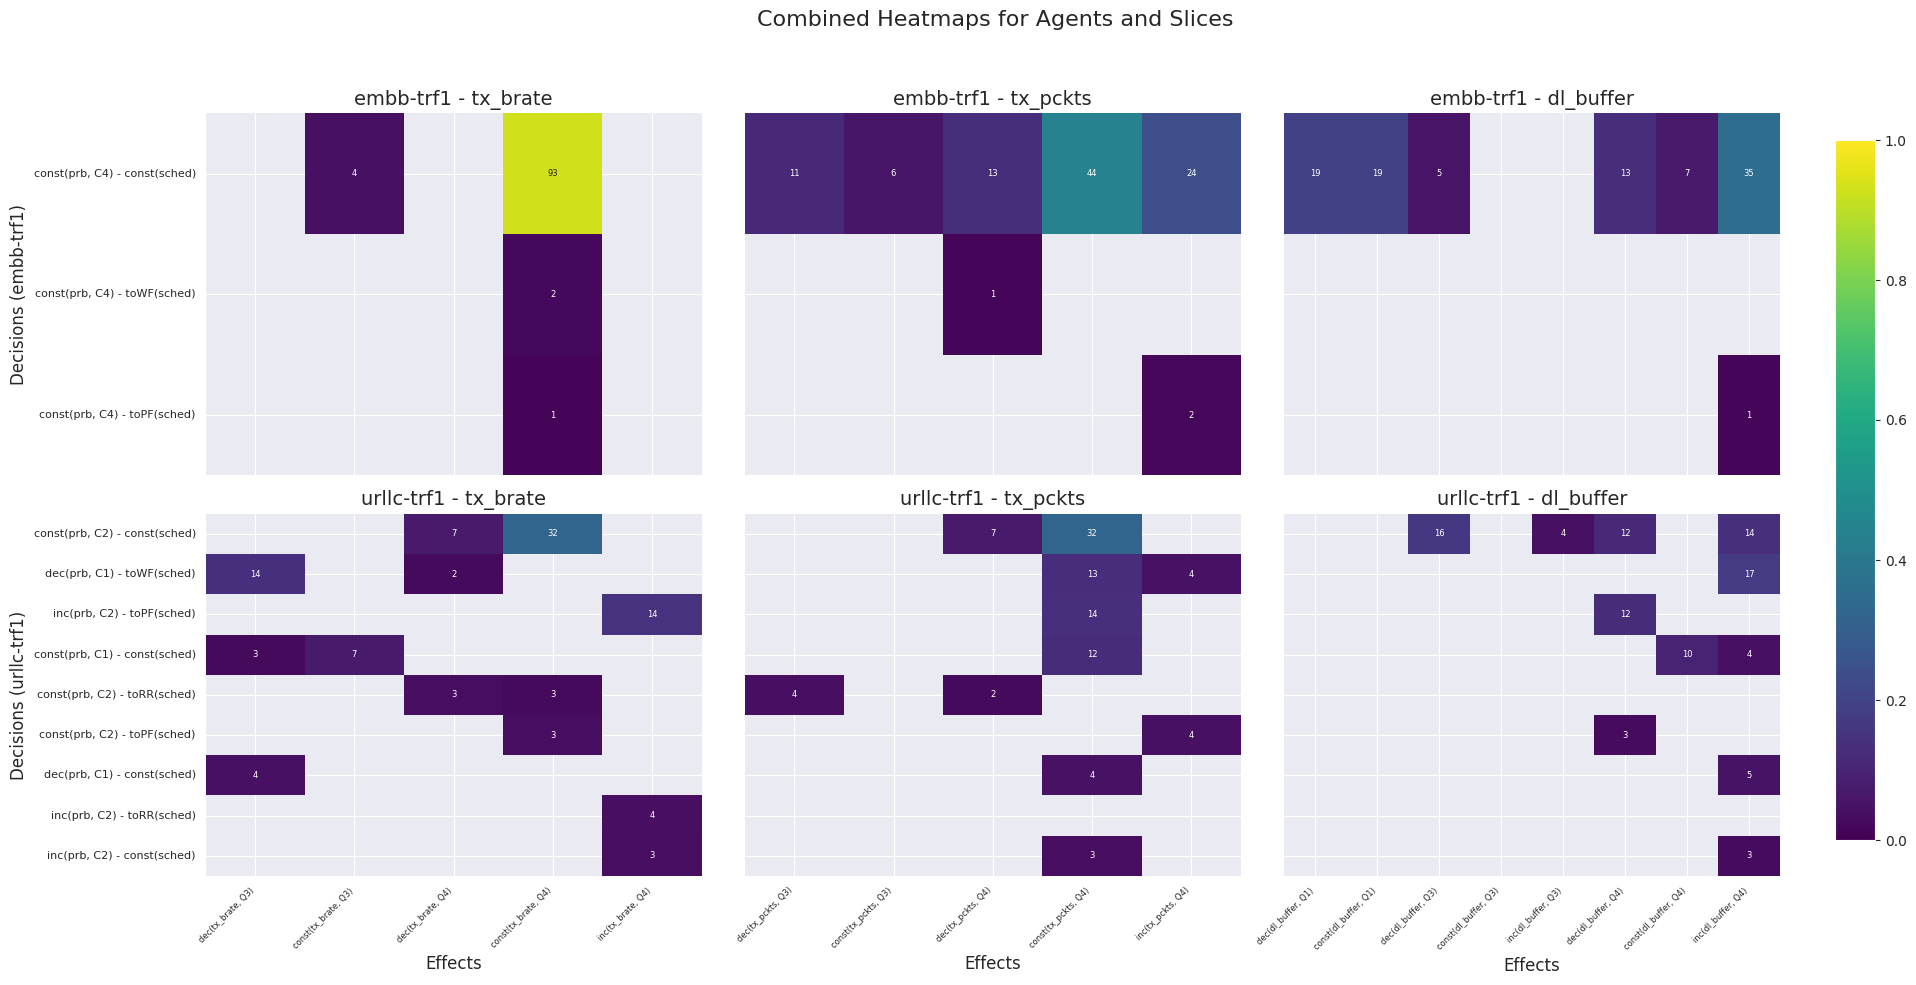

Combined heatmap has been generated and saved as PDF and LaTeX files.


In [6]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    """
    根据SYMBXRL论文中的解释性分析需求，生成组合热力图
    用于展示不同DRL代理在移动网络管理中的决策效果分布
    """
    cmap = 'viridis'  # 使用viridis颜色映射，符合科学可视化标准

    # Define the threshold values for each agent
    # 根据论文中不同代理的性能特点设置不同的显示阈值
    # embb-trf1代理主要优化吞吐量，效果更集中，使用较低阈值
    # urllc-trf1代理处理延迟敏感业务，效果更分散，使用较高阈值
    agent_thresholds = {
        "embb-trf1": 0.01,  # 1 percent # 1%阈值：只显示概率大于1%的效果
        "urllc-trf1": 0.02  # 2 percent # 2%阈值：只显示概率大于2%的效果
    }

    def format_value(val, threshold):
        """
        格式化显示值，基于论文中的符号表示方法
        将数值概率转换为百分比整数显示，便于人类理解
        """
        if np.isnan(val): # 空值不显示，减少视觉噪音
            return ''
        if val >= threshold: # 只显示超过阈值的重要数值
            return f'{round(val * 100):d}' # 转换为整数百分比，符合论文中的量化表示
        return '' # 小概率事件不显示，保持热力图简洁

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
     # 创建2行3列的子图布局，对应论文中的多代理多KPI比较分析
    # 行：不同代理（embb-trf1 vs urllc-trf1）
    # 列：不同KPI指标（tx_brate, tx_pckts, dl_buffer）
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    # 初始化数据存储结构，用于后续的符号推理分析
    row_filtered_decisions_list = []      # 存储过滤后的符号化决策【纵轴-决策】
    row_filtered_div_matrices_list = []   # 存储决策效果的概率分布矩阵【中间-二维数据】
    row_filtered_effects_list = []        # 存储符号化效果表示【横轴-状态】

    # 第一阶段：数据预处理和符号化转换
    # 遍历每个DRL代理，进行符号表示生成（对应论文中的Symbolic Representation Generator）
    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data'] # 获取代理的原始数值数据
        agent_name = slice_id['agent'] # 代理标识符
        threshold = agent_thresholds[agent_name] # 获取该代理的显示阈值
        
        # Get unique decisions for this slice
        # 提取独属于这个切片的符号化决策
        # 这些决策对应论文中FOL表示的符号化动作
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()  # 按频率排序

        # Initialize a mask for significant decisions across all KPIs
        # 创建显著决策掩码：识别在任一KPI中有显著效果的决策
        # 这对应论文中的"identifying flaws in the design process"
        significant_decisions_mask = np.zeros(len(sorted_slice_decisions), dtype=bool)

        # First pass: determine significant decisions across all KPIs
        # 对每个KPI进行概率分析，识别重要决策模式
        for kpi in kpis:
            kpi_effects = effects_list[kpi] # 获取该KPI的符号化效果集合
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

             # 为每个符号化决策计算效果分布概率
            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    # 计算该决策导致的各种符号化效果的出现频率
                    # 对应论文中的probabilistic analysis方法
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values
            # 归一化为概率分布，便于跨决策比较
            div_matrix = div_matrix / np.sum(div_matrix)
            # 更新显著决策掩码：标记在任何效果维度上超过阈值的决策
            # 这有助于发现代理的决策模式（论文中的decision-making strategies）
            significant_decisions_mask |= np.any(div_matrix > threshold, axis=1)

        # Filter decisions using the unified mask
        # 应用过滤：只保留有显著效果的决策，减少视觉复杂度
        filtered_decisions = np.array(sorted_slice_decisions)[significant_decisions_mask]

        # Second pass: create filtered matrices for each KPI
        # 第二阶段：为每个KPI创建过滤后的符号表示矩阵
        filtered_div_matrices = []
        filtered_effects_list = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi] # KPI特定的符号化效果
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))
            # 重新计算过滤后的概率分布矩阵
            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values
            # 归一化并应用过滤掩码
            div_matrix = div_matrix / np.sum(div_matrix)
            filtered_div_matrix = div_matrix[significant_decisions_mask]

            # Re-normalize the filtered matrix
             # 重新归一化过滤后的矩阵，保持概率完整性
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)
            # 存储处理后的数据用于可视化
            filtered_div_matrices.append(filtered_div_matrix)
            filtered_effects_list.append(kpi_effects)

        # Store the filtered data for this row
        # 保存处理后的符号表示数据
        # 这些数据对应论文中Knowledge Graph的构建基础
        row_filtered_decisions_list.append([filtered_decisions] * len(kpis))
        row_filtered_div_matrices_list.append(filtered_div_matrices)
        row_filtered_effects_list.append(filtered_effects_list)

    # Determine columns to keep across both rows for each KPI
    # 第三阶段：统一效果列过滤，确保比较的一致性
    # 对应论文中"enabling comparison between different agents"的目标
    final_filtered_effects_list = []
    for kpi_idx in range(len(kpis)):
         # 创建组合掩码：保留在任一代理中显著的效果
        # 这确保了比较的公平性和一致性
        combined_mask = np.zeros(len(effects_list[kpis[kpi_idx]]), dtype=bool)
        for row_filtered_div_matrices in row_filtered_div_matrices_list:
            combined_mask |= np.any(row_filtered_div_matrices[kpi_idx] > 0.008, axis=0)
        # 应用最终的效果过滤
        final_filtered_effects = np.array(effects_list[kpis[kpi_idx]])[combined_mask]
        final_filtered_effects_list.append(final_filtered_effects)

        # Re-filter the matrices based on the combined mask
         # 同步更新两个代理的数据矩阵，确保列对齐
        for row in range(2):
            row_filtered_div_matrices_list[row][kpi_idx] = row_filtered_div_matrices_list[row][kpi_idx][:, combined_mask]

    # Plot the heatmaps
    # 第四阶段：可视化生成 - 创建组合热力图
    # 这部分对应论文中的Explanation Engine功能
    for row in range(2): # 遍历两个代理（embb-trf1和urllc-trf1）
        agent_name = agents[row]
        threshold = agent_thresholds[agent_name] # 代理特定的显示阈值
        # 遍历三个KPI指标，在每个子图中绘制热力图
        for col, (ax, kpi, filtered_div_matrix, filtered_decisions, final_filtered_effects) in enumerate(zip(
                axs[row], kpis, row_filtered_div_matrices_list[row], row_filtered_decisions_list[row], final_filtered_effects_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            # 数据完整性检查：确保概率分布正确归一化
            # 这是符号推理可靠性的基础
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for agent {agents[row]}, KPI {kpi} is {total_sum}, which is not 1.")

            # Mask values lower than the threshold
            # 应用显示掩码：将低于阈值的数据设为NaN（不显示）
            # 这提高了可视化的可解释性，突出重要模式
            display_matrix = np.where(filtered_div_matrix >= threshold, filtered_div_matrix, np.nan)


            # Re-normalize the display values to ensure the sum is 1
             # 重新归一化显示矩阵，保持视觉准确性
            display_matrix = display_matrix / np.nansum(display_matrix)

            # Create a custom annotation array
            # 创建注释文本：将概率值转换为人类可读的百分比
            # 对应论文中"human-interpretable explanations"的目标
            annot = np.vectorize(format_value)(display_matrix, threshold)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            # 使用seaborn绘制热力图
            # 颜色映射从0到1，便于直观理解概率大小
            sns.heatmap(display_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6}, mask=np.isnan(display_matrix))
            # 设置子图标题：明确标识代理和KPI
            # 这有助于读者理解每个子图的上下文
            ax.set_title(f'{agents[row]} - {kpi}', fontsize=14)

            # 只在最后一行显示x轴标签，避免重复
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Y轴设置：只在第一列显示决策标签
            # 减少视觉混乱，提高可读性
            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel(f'Decisions ({agents[row]})', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])# 其他列隐藏y轴标签
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(final_filtered_effects)) + 0.5)
            ax.set_xticklabels(final_filtered_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        # 第一行隐藏x轴标签，保持布局整洁
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    # 添加统一的颜色条，提供概率值的视觉参考
    # 位置参数精心调整，避免与子图重叠
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    # 布局优化：调整子图间距，确保标签不重叠
    plt.subplots_adjust(wspace=0.001, hspace=0.01)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 为颜色条留出空间
    
    # Save the figure as PDF
    # 输出生成：保存高分辨率PDF用于论文发表
    # 600 DPI确保印刷质量，符合学术出版标准
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    # 同时生成LaTeX格式，便于直接嵌入学术论文
    # 这体现了论文中"reproducibility"的承诺
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    # plt.close()
    plt.show()

# The rest of your code remains the same
# 主执行程序：配置分析参数并运行可视化
analysis_name = "Plots_for_Paper"  # 分析会话标识符
agents = ["embb-trf1", "urllc-trf1"]  # 要比较的DRL代理
# KPI选择基于论文中的关键性能指标：
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']  # 吞吐量、数据包数、延迟缓冲区
slices = [0]  # 聚焦分析第一个网络slice，简化比较
effects_list = create_effects_list()  # 生成符号化效果表示

# 准备代理数据字典：整合不同代理的符号化数据
agent_data_dict = {}

for agent in agents:
    # 获取代理实验配置信息
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()  # 初始化数据容器

    # 整合不同用户场景的数据（用户数3-6）
    # 这对应论文中验证方法的部分，确保分析的全面性
    for number_of_user in range(3, 7):
        # 处理原始KPI和决策数据【清洗】
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        # 转换为符号表示：数值数据 -> FOL符号【SRG】
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user # 记录用户数量上下文
        # 合并PRB和调度决策，创建完整的符号化动作表示
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        # 累积所有用户场景的数据
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        # 及时清理内存，处理大规模数据
        del symbolic_effects, kpi_data, decision_data

    # 存储处理后的数据，聚焦slice 0的分析
    # 这对应论文中针对特定网络切片的深入分析
    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
# 创建输出目录并生成最终可视化
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3.2_masked_No_DN_Filter_White/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

# 执行组合热力图生成函数
# 这是SYMBXRL解释性分析流程的可视化输出阶段
plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

In [9]:
agent_data_dict

{'embb-trf1': {'data':       timestep  slice_id    prb_decision sched_decision             tx_brate  \
  0            2         0  const(prb, C4)    toWF(sched)    inc(tx_brate, Q4)   
  3            3         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  6            4         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  9            5         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  12           6         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  ...        ...       ...             ...            ...                  ...   
  1812       606         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  1815       607         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  1818       608         0  const(prb, C4)   const(sched)  const(tx_brate, Q4)   
  1821       609         0  const(prb, C4)   const(sched)  const(tx_brate, Q3)   
  1824       610         0  const(prb, C4)   const(sched)  const(tx_brate, Q4

#### With one Decimal Points

In [ ]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    # Define the threshold values for each agent
    agent_thresholds = {
        "embb-trf1": 0.005,  # 1 percent
        "urllc-trf1": 0.02  # 2 percent
    }

    def format_value(val, threshold):
        if val >= threshold:
            return f'{val * 100:.1f}'
        return ''

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    # Initialize lists to store data for both rows
    row_filtered_decisions_list = []
    row_filtered_div_matrices_list = []
    row_filtered_effects_list = []

    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data']
        agent_name = slice_id['agent']
        threshold = agent_thresholds[agent_name]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a list to store filtered decisions and their corresponding matrices for each KPI
        filtered_decisions_list = []
        filtered_div_matrices = []
        filtered_effects_list = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            # Initialize the matrix for the current KPI and decisions in this slice
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            # Normalize the matrix for this slice
            div_matrix = div_matrix / np.sum(div_matrix)

            # Filter out rows where no cell has a value greater than the threshold
            row_mask = np.any(div_matrix > threshold, axis=1)
            filtered_div_matrix = div_matrix[row_mask]
            filtered_decisions = np.array(sorted_slice_decisions)[row_mask]

            # Re-normalize the filtered matrix to ensure the sum is 1
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)

            # Append the filtered matrices and decisions to the lists
            filtered_decisions_list.append(filtered_decisions)
            filtered_div_matrices.append(filtered_div_matrix)
            filtered_effects_list.append(kpi_effects)

        # Store the filtered data for this row
        row_filtered_decisions_list.append(filtered_decisions_list)
        row_filtered_div_matrices_list.append(filtered_div_matrices)
        row_filtered_effects_list.append(filtered_effects_list)

    # Determine columns to keep across both rows for each KPI
    final_filtered_effects_list = []
    for kpi_idx in range(len(kpis)):
        combined_mask = np.zeros(len(effects_list[kpis[kpi_idx]]), dtype=bool)
        for row_filtered_div_matrices in row_filtered_div_matrices_list:
            combined_mask |= np.any(row_filtered_div_matrices[kpi_idx] > 0.008, axis=0)
        final_filtered_effects = np.array(effects_list[kpis[kpi_idx]])[combined_mask]
        final_filtered_effects_list.append(final_filtered_effects)

        # Re-filter the matrices and decisions based on the combined mask
        for row in range(2):
            row_filtered_div_matrices_list[row][kpi_idx] = row_filtered_div_matrices_list[row][kpi_idx][:, combined_mask]

    # Plot the heatmaps
    for row in range(2):
        agent_name = agents[row]
        threshold = agent_thresholds[agent_name]
        for col, (ax, kpi, filtered_div_matrix, filtered_decisions, final_filtered_effects) in enumerate(zip(
                axs[row], kpis, row_filtered_div_matrices_list[row], row_filtered_decisions_list[row], final_filtered_effects_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for agent {agents[row]}, KPI {kpi} is {total_sum}, which is not 1.")

            # Create a custom annotation array
            annot = np.vectorize(format_value)(filtered_div_matrix, threshold)

            # Re-normalize the display values to ensure the sum is 1
            display_matrix = np.where(filtered_div_matrix >= threshold, filtered_div_matrix, 0)
            display_matrix = display_matrix / np.sum(display_matrix)

            annot = np.vectorize(format_value)(display_matrix, threshold)

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(display_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6})
            
            ax.set_title(f'{agents[row]} - {kpi}', fontsize=14)
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel(f'Decisions ({agents[row]})', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(final_filtered_effects)) + 0.5)
            ax.set_xticklabels(final_filtered_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.subplots_adjust(wspace=0.001, hspace=0.01)  # Reduce these values to decrease space between subplots
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save the figure as PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    plt.close()


analysis_name = "Plots_for_Paper"
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0]
effects_list = create_effects_list()

agent_data_dict = {}

for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in range(3, 7):
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3.2_masked_With_DN/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

#### With decimal points by filtering out empty cells 

In [ ]:
def plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_path):
    cmap = 'viridis'

    # Define the threshold values for each agent
    agent_thresholds = {
        "embb-trf1": 0.005,  # 1 percent
        "urllc-trf1": 0.02  # 2 percent
    }

    def format_value(val, threshold):
        if val >= threshold:
            return f'{val * 100:.1f}'
        return ''

    # Initialize a 2x3 layout for the combined plot (2 agents x 3 KPIs)
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Combined Heatmaps for Agents and Slices', fontsize=16)

    # Initialize lists to store data for both rows
    row_filtered_decisions_list = []
    row_filtered_div_matrices_list = []
    row_filtered_effects_list = []

    for row, (agent, slice_id) in enumerate(agent_data_dict.items()):
        slice_data = slice_id['data']
        agent_name = slice_id['agent']
        threshold = agent_thresholds[agent_name]
        
        # Get unique decisions for this slice
        slice_decisions = slice_data['combined_decision'].unique()
        decision_counts = slice_data['combined_decision'].value_counts()
        sorted_slice_decisions = decision_counts.index.tolist()

        # Initialize a list to store filtered decisions and their corresponding matrices for each KPI
        filtered_decisions_list = []
        filtered_div_matrices = []
        filtered_effects_list = []

        for kpi in kpis:
            kpi_effects = effects_list[kpi]
            # Initialize the matrix for the current KPI and decisions in this slice
            div_matrix = np.zeros((len(sorted_slice_decisions), len(kpi_effects)))

            for j, decision in enumerate(sorted_slice_decisions):
                decision_data = slice_data[slice_data['combined_decision'] == decision]
                
                if not decision_data.empty:
                    effect_counts = decision_data[kpi].value_counts().reindex(kpi_effects, fill_value=0)
                    div_matrix[j] = effect_counts.values

            # Normalize the matrix for this slice
            div_matrix = div_matrix / np.sum(div_matrix)

            # Filter out rows where no cell has a value greater than the threshold
            row_mask = np.any(div_matrix > threshold, axis=1)
            filtered_div_matrix = div_matrix[row_mask]
            filtered_decisions = np.array(sorted_slice_decisions)[row_mask]

            # Re-normalize the filtered matrix to ensure the sum is 1
            filtered_div_matrix = filtered_div_matrix / np.sum(filtered_div_matrix)

            # Append the filtered matrices and decisions to the lists
            filtered_decisions_list.append(filtered_decisions)
            filtered_div_matrices.append(filtered_div_matrix)
            filtered_effects_list.append(kpi_effects)

        # Store the filtered data for this row
        row_filtered_decisions_list.append(filtered_decisions_list)
        row_filtered_div_matrices_list.append(filtered_div_matrices)
        row_filtered_effects_list.append(filtered_effects_list)

    # Determine columns to keep across both rows for each KPI
    final_filtered_effects_list = []
    for kpi_idx in range(len(kpis)):
        combined_mask = np.zeros(len(effects_list[kpis[kpi_idx]]), dtype=bool)
        for row_filtered_div_matrices in row_filtered_div_matrices_list:
            combined_mask |= np.any(row_filtered_div_matrices[kpi_idx] > 0.008, axis=0)
        final_filtered_effects = np.array(effects_list[kpis[kpi_idx]])[combined_mask]
        final_filtered_effects_list.append(final_filtered_effects)

        # Re-filter the matrices and decisions based on the combined mask
        for row in range(2):
            row_filtered_div_matrices_list[row][kpi_idx] = row_filtered_div_matrices_list[row][kpi_idx][:, combined_mask]

    # Plot the heatmaps
    for row in range(2):
        agent_name = agents[row]
        threshold = agent_thresholds[agent_name]
        for col, (ax, kpi, filtered_div_matrix, filtered_decisions, final_filtered_effects) in enumerate(zip(
                axs[row], kpis, row_filtered_div_matrices_list[row], row_filtered_decisions_list[row], final_filtered_effects_list)):
            # Verify that the sum is 1 (or very close to 1 due to floating-point precision)
            total_sum = np.sum(filtered_div_matrix)
            if not np.isclose(total_sum, 1.0, atol=1e-6):
                print(f"Warning: Sum for agent {agents[row]}, KPI {kpi} is {total_sum}, which is not 1.")

            # Create a custom annotation array
            annot = np.vectorize(format_value)(filtered_div_matrix, threshold)

            # Re-normalize the display values to ensure the sum is 1
            display_matrix = np.where(filtered_div_matrix >= threshold, filtered_div_matrix, 0)
            display_matrix = display_matrix / np.sum(display_matrix)

            # Update annotation array after re-normalization
            annot = np.vectorize(format_value)(display_matrix, threshold)

            # Create a mask to hide values below the threshold
            mask = display_matrix == 0

            # Plot heatmap with fixed scale from 0 to 1 and display formatted values
            sns.heatmap(display_matrix, ax=ax, cmap=cmap, vmin=0, vmax=1, cbar=False, 
                        annot=annot, fmt='', annot_kws={'size': 6}, mask=mask)
            
            ax.set_title(f'{agents[row]} - {kpi}', fontsize=14)
            if row == 1:
                ax.set_xlabel('Effects', fontsize=12)

            # Only set y-axis labels for the first subplot in each row
            if col == 0:
                ax.set_ylabel(f'Decisions ({agents[row]})', fontsize=12)
                ax.set_yticks(np.arange(len(filtered_decisions)) + 0.5)
                ax.set_yticklabels(filtered_decisions, rotation=0, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # Adjust x-axis ticks with rotated labels
            ax.set_xticks(np.arange(len(final_filtered_effects)) + 0.5)
            ax.set_xticklabels(final_filtered_effects, rotation=45, ha='right', va='top', fontsize=6)

        # Remove x-axis labels for the first row
        if row == 0:
            for col in range(3):
                axs[row, col].set_xticklabels([])

    # Add a single color bar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.subplots_adjust(wspace=0.001, hspace=0.01)  # Reduce these values to decrease space between subplots
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save the figure as PDF
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    
    # Save the figure as LaTeX using tikzplotlib
    tex_output_path = output_path.replace('.pdf', '.tex')
    tikzplotlib.save(tex_output_path)
    
    plt.close()


analysis_name = "Plots_for_Paper"
agents = ["embb-trf1", "urllc-trf1"]
kpis = ['tx_brate', 'tx_pckts', 'dl_buffer']
slices = [0]
effects_list = create_effects_list()

agent_data_dict = {}

for agent in agents:
    agent_info = AGENT_EXPERIMENT_INFO[agent]
    agent_symbolic_data = pd.DataFrame()
    for number_of_user in range(3, 7):
        kpi_data, decision_data = handle_data(agent_info, number_of_user)
        symbolic_effects, _ = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_user)
        symbolic_effects['user_num'] = number_of_user
        symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        agent_symbolic_data = pd.concat([agent_symbolic_data, symbolic_effects], axis=0)
        del symbolic_effects, kpi_data, decision_data

    agent_data_dict[agent] = {'data': agent_symbolic_data[agent_symbolic_data['slice_id'] == 0], 'agent': agent}

# Generate and save the heatmap
plot_path = create_plot_dir_for_results(analysis_name + f"/4_Heatmaps/Heatmap_of_Decision_Effect_per_slice_specific_scenario/V3.2_masked_With_DN_Filter_white/")
output_file = os.path.join(plot_path, f"combined_heatmaps.pdf")

plot_combined_heatmaps_for_paper(agent_data_dict, agents, effects_list, kpis, slices, output_file)

print("Combined heatmap has been generated and saved as PDF and LaTeX files.")

##
------